# Модель для прогнозирования оттока клиентов для сервиса доставки кофе

- **Автор:** Жукова Галина
- **Дата:** 24.11.2025

## Постановка задачи машинного обучения

**Цель - разработать интерпретируемую модель машинного обучения для прогнозирования оттока клиентов сервиса доставки кофе Happy Beans Coffee с целью их последующего удержания.**

**- Тип задачи**

Бинарная классификация.

**- Целевая переменная**

`churn` — бинарный признак, показывающий, перестал ли пользователь пользоваться сервисом.

 - Класс 1 (Positive): «Клиент может уйти».

 - Класс 0 (Negative): «Клиент лояльный».

**- Признаки**

Набор из 25 признаков, описывающих поведение клиента, его транзакционную историю и демографические данные. Включают:

**Поведенческие:** 

`days_since_last_order` - количество дней, прошедших с последнего заказа

`order_frequency_week` - среднее число заказов в неделю

`app_opens_per_week` - сколько раз за неделю пользователь в среднем открывал приложение доставки кофе

**Финансовые:**

`avg_order_value` -  средний чек, в рублях

`total_spent_last_month` -  сумма заказов за последний месяц

`discount_usage_rate` -  доля заказов со скидкой за последний месяц

**Продуктовые:**

`last_coffee_type` - сорт кофе, купленный пользователем в последний раз на момент сбора данных

`preferred_roast` - предпочитаемый тип обжарки

`milk_preference` - предпочитаемый тип молока

**Технические:**

`app_crashes_last_month` -  сколько раз приложение зависало за последний месяц

`phone_type` - тип устройства, с которого пользователь чаще всего совершал покупки

**Демографические/контекстуальные:**

`geo_id` - идентификатор региона пользователя

`seasons` - текущее время года

**- Метрики машинного обучения**

1. Основная метрика: Precision-Recall AUC (PR AUC). Выбрана из-за сильного дисбаланса классов (большинство клиентов — лояльные). Эта метрика фокусируется на качестве предсказания класса «уходящие», что критически важно для бизнеса.

2. Дополнительные ключевые метрики:

    - Precision (Точность): Минимизация ложных срабатываний, чтобы не тратить бюджет на удержание лояльных клиентов.

    - Recall (Полнота): Максимальный охват реально уходящих клиентов.

    - F1-мера: Поиск баланса между Precision и Recall.

**- Критерии успешности проекта**

1. Качество модели: Финальная модель должна превосходить по PR AUC базовую модель (DummyClassifier), обученную на исходных данных.

2. Интерпретируемость: Модель (например, LogisticRegression) должна позволять анализировать важность признаков для понимания тригеров оттока.

3. Готовность к внедрению: Проект включает сохраненный пайплайн предобработки данных и обученной модели (с помощью pickle/joblib), готовый к промышленной эксплуатации.

**- Дополнительные критерии качества:**

1. Воспроизводимость: Использование random_state для всех алгоритмов с целью гарантии одинаковых результатов при повторных запусках.

2. Устойчивость: Корректная обработка пропущенных значений и выбросов.

3. Надёжность оценки: Использование кросс-валидации для получения устойчивой оценки качества модели, а не разового разбиения на train/test.

4. Эффективность расходов: Модель должна помочь бизнесу сместить фокус с дорогого привлечения новых клиентов на более дешёвое удержание существующих, оптимизировав маркетинговый бюджет.

### Содержимое проекта

2 [Подключение и настройка библиотек](#get)

3 [Загрузка датасета](#get_date)

4 [Исследовательский анализ данных](#analiz)

5 [Предобработка данных](#pred)

6 [Обучение моделей](#teach)
     
7 [Создание новых признаков](#new_pr)

8 [Экперименты с гиперпараметрами](#giper)

9 [Подготовка финальной модели](#final)

10 [Общие выводы и рекомендации по дальнейшей работе](#vivod)

11 [Сохранение модели для продакшена](#save)

<a id="get"></a>
## Подключение и настройка библиотек

Загрузим необходимые библиотеки для анализа данных. Зафиксируем `random_state`.


In [1]:
!pip install --upgrade scikit-learn -q
!pip install phik -U -q

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from phik import phik_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    precision_recall_curve, 
    average_precision_score,
    f1_score,
    precision_score,
    recall_score,
    auc,
    roc_auc_score
)
import warnings
warnings.filterwarnings('ignore')
# Фиксируем random_state для воспроизводимости результатов
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

<a id="get_date"></a>
## Загрузка датасета

- Загрузим данные из CSV-файла `https://code.s3.yandex.net/datasets/coffee_churn_dataset.csv`. При использовании метода read_csv установим правильные значения для параметров `sep` и `decimal`: в качестве разделителя столбцов используется символ запятой (`","`), а параметр `decimal="."`.
- Проверим правильность загрузки и соответствие данных описанию в задании.
- С помощью методов библиотеки `pandas` выведем общие сведения о данных.

In [3]:
# Загрузка данных с указанием параметров
url = "https://code.s3.yandex.net/datasets/coffee_churn_dataset.csv"
try:
    df = pd.read_csv(url, sep=',', decimal='.')
    print("Данные успешно загружены")
    print(f"Размер датасета: {df.shape[0]} строк, {df.shape[1]} столбцов")
except Exception as e:
    print(f"Ошибка при загрузке данных: {e}")

Данные успешно загружены
Размер датасета: 10450 строк, 27 столбцов


In [4]:
# Проверка правильности загрузки и соответствия описанию
print("=== ПРОВЕРКА ЗАГРУЗКИ ДАННЫХ ===")
print("\nПервые 5 строк данных:")
display(df.head())

print("\nПоследние 5 строк данных:")
display(df.tail())

print("\nНазвания столбцов:")
print(df.columns.tolist())
print(f"\nЦелевая переменная 'churn' присутствует: {'churn' in df.columns}")

=== ПРОВЕРКА ЗАГРУЗКИ ДАННЫХ ===

Первые 5 строк данных:


,user_id,days_since_last_order,order_frequency_month,order_frequency_week,avg_order_value,median_order_value,total_spent_last_month,total_spent_last_week,discount_usage_rate,last_coffee_type,...,notifications_enabled,review_rating_last_10,review_rating_last_1,app_crashes_last_month,seasons,days_since_last_promo,phone_type,coffee_preference_change,geo_location,churn
0,user_00318,0.0,12.942519,NaN,316.833872,260.645090,3089.991009,NaN,0.337031,blend,...,1.0,5.176792,3.302238,NaN,summer,6.0,android,0.0,geo_75,1
1,user_07234,2.0,1.569146,0.214494,780.135158,540.597850,998.380941,107.369409,0.547659,arabica,...,1.0,4.392991,NaN,0.0,autumn,16.0,ios,0.0,geo_95,0
2,user_04816,11.0,2.996666,0.771864,682.636256,471.494559,1328.140204,392.600011,0.120258,arabica,...,1.0,4.977712,4.379219,0.0,spring,11.0,web,1.0,geo_25,0
3,user_04419,0.0,4.299255,1.210480,2115.487425,708.529812,2999.628366,1084.352054,NaN,robusta,...,1.0,3.712526,3.043618,0.0,summer,3.0,android,0.0,geo_2,0
4,user_09698,3.0,7.249864,1.761027,3519.602170,1199.372894,8377.729478,2551.775211,0.074990,robusta,...,0.0,4.528271,5.642993,1.0,winter,14.0,ios,0.0,geo_19,1



Последние 5 строк данных:


,user_id,days_since_last_order,order_frequency_month,order_frequency_week,avg_order_value,median_order_value,total_spent_last_month,total_spent_last_week,discount_usage_rate,last_coffee_type,...,notifications_enabled,review_rating_last_10,review_rating_last_1,app_crashes_last_month,seasons,days_since_last_promo,phone_type,coffee_preference_change,geo_location,churn
10445,user_05734,5.0,NaN,0.807372,288.187339,NaN,465.497296,82.772110,0.285469,arabica,...,1.0,3.149287,5.180760,NaN,summer,2.0,android,NaN,NaN,0
10446,user_05191,NaN,8.265273,1.942752,1151.879696,392.095861,3323.512340,535.414300,0.172886,blend,...,1.0,5.144074,2.438754,NaN,winter,17.0,ios,1.0,geo_36,0
10447,user_05390,0.0,4.303173,1.029802,1303.253909,477.969319,1854.476109,551.436986,0.502961,arabica,...,1.0,3.975122,5.018790,1.0,winter,7.0,ios,0.0,geo_12,0
10448,user_00860,7.0,1.964595,0.350771,965.339923,465.489241,833.596910,203.599663,0.137200,arabica,...,0.0,4.564480,2.024267,1.0,autumn,NaN,ios,0.0,geo_3,0
10449,user_07270,1.0,9.731682,2.257865,1019.691126,454.191202,4343.690591,851.127412,NaN,robusta,...,1.0,4.827017,4.485083,0.0,summer,18.0,ios,0.0,geo_1,0



Названия столбцов:
['user_id', 'days_since_last_order', 'order_frequency_month', 'order_frequency_week', 'avg_order_value', 'median_order_value', 'total_spent_last_month', 'total_spent_last_week', 'discount_usage_rate', 'last_coffee_type', 'preferred_roast', 'milk_preference', 'seasonal_menu_tried', 'coffee_bean_origin', 'last_drink_size', 'subscription_status', 'app_opens_per_week', 'notifications_enabled', 'review_rating_last_10', 'review_rating_last_1', 'app_crashes_last_month', 'seasons', 'days_since_last_promo', 'phone_type', 'coffee_preference_change', 'geo_location', 'churn']

Целевая переменная 'churn' присутствует: True


In [5]:
# Общие сведения о данных
print("=== ОБЩИЕ СВЕДЕНИЯ О ДАННЫХ ===")
print("\nБазовая информация:")
df.info()

print("\nСтатистическое описание числовых признаков:")
display(df.describe())

=== ОБЩИЕ СВЕДЕНИЯ О ДАННЫХ ===

Базовая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10450 entries, 0 to 10449
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   user_id                   10450 non-null  object 
 1   days_since_last_order     9505 non-null   float64
 2   order_frequency_month     9850 non-null   float64
 3   order_frequency_week      10062 non-null  float64
 4   avg_order_value           9867 non-null   float64
 5   median_order_value        9619 non-null   float64
 6   total_spent_last_month    10156 non-null  float64
 7   total_spent_last_week     9506 non-null   float64
 8   discount_usage_rate       10053 non-null  float64
 9   last_coffee_type          10192 non-null  object 
 10  preferred_roast           10334 non-null  object 
 11  milk_preference           9782 non-null   object 
 12  seasonal_menu_tried       9461 non-null   float64
 13  coffee_b

,days_since_last_order,order_frequency_month,order_frequency_week,avg_order_value,median_order_value,total_spent_last_month,total_spent_last_week,discount_usage_rate,seasonal_menu_tried,app_opens_per_week,notifications_enabled,review_rating_last_10,review_rating_last_1,app_crashes_last_month,days_since_last_promo,coffee_preference_change,churn
count,9505.000000,9850.000000,10062.000000,9867.000000,9619.000000,10156.000000,9506.000000,10053.000000,9461.000000,9554.000000,9913.000000,9757.000000,9593.000000,9729.000000,9719.000000,9840.000000,10450.000000
mean,4.394214,4.025666,0.930686,1063.741207,452.651500,1946.132979,413.004760,0.284446,0.701194,11.330895,0.753052,4.206709,4.022460,1.013362,14.554584,0.192480,0.060191
std,4.858757,2.826144,0.657261,707.713396,258.657571,2370.619590,445.634902,0.158735,0.457759,14.528887,0.431258,0.782212,1.207883,1.010342,15.308869,0.394268,0.237852
min,0.000000,0.011046,-0.169131,-32.075932,-10.353340,-43.716463,-2290.559468,0.002162,0.000000,0.000000,0.000000,1.415526,-0.897000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.937767,0.445185,552.898663,262.908598,629.680382,136.565833,0.159884,0.000000,6.313628,1.000000,3.675543,3.214157,0.000000,4.000000,0.000000,0.000000
50%,3.000000,3.381094,0.784839,898.643524,406.456818,1300.409757,288.277327,0.264583,1.000000,9.228383,1.000000,4.203555,3.990032,1.000000,10.000000,0.000000,0.000000
75%,6.000000,5.439363,1.262350,1406.332153,590.418070,2481.650495,549.699420,0.387056,1.000000,12.726649,1.000000,4.717292,4.845225,2.000000,20.000000,0.000000,0.000000
max,40.000000,27.389318,6.302624,5901.965278,2189.101644,79298.849570,8615.988952,0.887301,1.000000,224.587876,1.000000,7.384425,8.558443,7.000000,140.000000,1.000000,1.000000


In [6]:
# Общая оценка полноты данных
total_cells = df.shape[0] * df.shape[1]
missing_cells = df.isnull().sum().sum()
completeness = ((total_cells - missing_cells) / total_cells) * 100
print(f"Полнота данных: {completeness:.1f}%")

Полнота данных: 94.6%


**Предварительные выводы по результатам проверки данных:**

1. Пропущенные значения во многих признаках. Всего 27 признаков, но только `user_id` и `churn` не имеют пропусков. Наибольшие проблемы: `days_since_last_order` (945 пропусков), `seasonal_menu_tried` (989 пропусков)

2. Некорректные значения в числовых признаках. Отрицательные значения: `order_frequency_week` (-0.17), `avg_order_value` (-32), `median_order_value` (-10), `total_spent_last_week` (-2290). Невозможные значения: review_rating_last_1 (-0.9) - рейтинг не может быть отрицательным

3. Выбросы в данных. `app_opens_per_week`: max 224 (при mean 11.3) - явный выброс, `total_spent_last_month`: max 79,298 руб (при mean 1,946) - аномалия, `days_since_last_promo`: max 140 дней (4.5 месяца)

4. Сильный дисбаланс классов. Целевая переменная `churn`: только 6% клиентов уходят (10450 * 0.06 ≈ 629 клиентов). Это подтверждает выбор PR AUC как основной метрики

НЕОБХОДИМЫЕ ДЕЙСТВИЯ ДЛЯ ПРЕДОБРАБОТКИ:

1. Обработка пропусков

2. Коррекция аномальных значений

**ВЫВОД:** Данные требуют серьезной предобработки, но при правильной обработке могут быть использованы для построения модели прогнозирования оттока. Дисбаланс классов подтверждает корректность выбора PR AUC в качестве основной метрики.

<a id="analiz"></a>
## Исследовательский анализ данных

1. Опишем целевую переменную. Обратим внимание на возможные особенности её распределения. 

2. Опишем признаки. Определим, все ли из них важны.

3. Обработаем пропущенные значения. Выберем стратегию заполнения пропусков.

4. Проанализируем категориальные признаки. Выясним, есть ли в данных признаки, которые можно кодировать. Определим, есть ли в данных признаки, которые можно удалить.

5. Проанализируем выбросы. Выберем способ, которым их можно обработать.

6. Посчитаем корреляции между признаками. Построим необходимые визуализации. Определим, есть ли признаки, которые можно убрать, на основании их корреляции с другими.

7. Напишем выводы по результатам исследовательского анализа данных.

In [7]:
# Детальный анализ целевой переменной
print("=== ДЕТАЛЬНЫЙ АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ===")

churn_stats = df['churn'].value_counts()
churn_percentage = df['churn'].value_counts(normalize=True) * 100

print(f"Распределение целевой переменной:")
print(f"Лояльные клиенты (0): {churn_stats[0]:,} ({churn_percentage[0]:.1f}%)")
print(f"Уходящие клиенты (1): {churn_stats[1]:,} ({churn_percentage[1]:.1f}%)")

=== ДЕТАЛЬНЫЙ АНАЛИЗ ЦЕЛЕВОЙ ПЕРЕМЕННОЙ ===
Распределение целевой переменной:
Лояльные клиенты (0): 9,821 (94.0%)
Уходящие клиенты (1): 629 (6.0%)


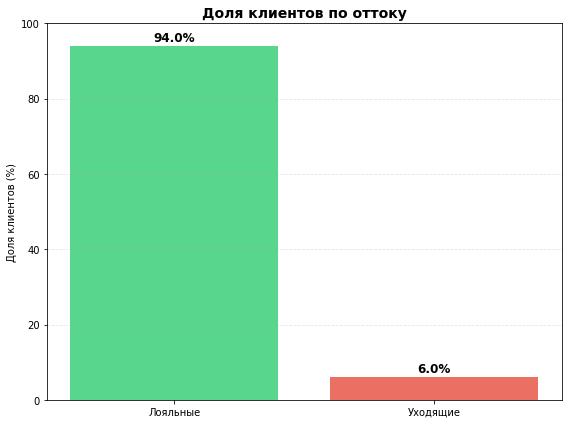

In [8]:
# Визуализация распределения
plt.figure(figsize=(8, 6))
colors = ['#2ecc71', '#e74c3c']
bars = plt.bar(['Лояльные', 'Уходящие'], churn_percentage.values, color=colors, alpha=0.8)
plt.title('Доля клиентов по оттоку', fontsize=14, fontweight='bold')
plt.ylabel('Доля клиентов (%)')
for bar, value in zip(bars, churn_percentage.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=12)
plt.ylim(0, 100)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

График наглядно демонстрирует сильный дисбаланс классов - всего 6% клиентов относятся к классу "уходящие"

In [9]:
# Поиск полных дубликатов (все столбцы одинаковые)
full_duplicates = df.duplicated().sum()
print(f"Полных дубликатов (все столбцы идентичны): {full_duplicates}")
if full_duplicates > 0:
    print("\nПримеры полных дубликатов:")
    duplicate_rows = df[df.duplicated(keep=False)]
    display(duplicate_rows.head(10))

Полных дубликатов (все столбцы идентичны): 0


In [10]:
# Анализ пропусков
missing_data = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_info = pd.DataFrame({
    'Пропуски': missing_data,
    'Процент': missing_percent
}).sort_values('Пропуски', ascending=False)

print("Пропущенные значения:")
display(missing_info[missing_info['Пропуски'] > 0])

Пропущенные значения:


,Пропуски,Процент
seasonal_menu_tried,989,9.464115
days_since_last_order,945,9.043062
total_spent_last_week,944,9.033493
subscription_status,938,8.976077
app_opens_per_week,896,8.574163
review_rating_last_1,857,8.200957
median_order_value,831,7.952153
days_since_last_promo,731,6.995215
app_crashes_last_month,721,6.899522
review_rating_last_10,693,6.631579


In [11]:
# Анализ типов признаков для выбора стратегии заполнения пропусков
print("=== СТРАТЕГИЯ ЗАПОЛНЕНИЯ ПРОПУСКОВ ===")

# Группируем признаки по типам и стратегиям заполнения
missing_strategy = {}

# 1. Бинарные признаки
binary_features = ['seasonal_menu_tried', 'notifications_enabled', 'coffee_preference_change']
for feature in binary_features:
    if feature in missing_info.index:
        missing_strategy[feature] = {
            'type': 'binary',
            'strategy': 'mode (most_frequent)',
            'reason': 'Дискретные значения 0/1, заполнение модой сохраняет распределение'
        }

# 2. Непрерывные числовые признаки
continuous_features = [
    'days_since_last_order', 'order_frequency_month', 'order_frequency_week',
    'avg_order_value', 'median_order_value', 'total_spent_last_month',
    'total_spent_last_week', 'discount_usage_rate', 'app_opens_per_week',
    'review_rating_last_10', 'review_rating_last_1', 'app_crashes_last_month',
    'days_since_last_promo'
]

for feature in continuous_features:
    if feature in missing_info.index:
        # Для некоторых признаков используем медиану, для других - 0
        if feature in ['days_since_last_order', 'app_crashes_last_month', 'days_since_last_promo']:
            strategy = 'median'
            reason = 'Умеренная вариативность, медиана устойчива к выбросам'
        else:
            strategy = 'median' 
            reason = 'Числовой признак с возможными выбросами, медиана предпочтительнее'
        
        missing_strategy[feature] = {
            'type': 'continuous',
            'strategy': strategy,
            'reason': reason
        }

# 3. Категориальные признаки
categorical_features = [
    'last_coffee_type', 'preferred_roast', 'milk_preference',
    'coffee_bean_origin', 'last_drink_size', 'subscription_status',
    'seasons', 'phone_type', 'geo_location'
]

for feature in categorical_features:
    if feature in missing_info.index:
        missing_strategy[feature] = {
            'type': 'categorical',
            'strategy': 'mode (most_frequent)',
            'reason': 'Категориальный признак, заполнение наиболее частой категорией'
        }

strategy_df = pd.DataFrame(missing_strategy).T
strategy_df['пропуски'] = missing_info['Пропуски']
strategy_df['процент'] = missing_info['Процент']
strategy_df = strategy_df.sort_values('процент', ascending=False)

print("Стратегии заполнения пропусков:")
display(strategy_df)

=== СТРАТЕГИЯ ЗАПОЛНЕНИЯ ПРОПУСКОВ ===
Стратегии заполнения пропусков:


,type,strategy,reason,пропуски,процент
seasonal_menu_tried,binary,mode (most_frequent),"Дискретные значения 0/1, заполнение модой сохр...",989,9.464115
days_since_last_order,continuous,median,"Умеренная вариативность, медиана устойчива к в...",945,9.043062
total_spent_last_week,continuous,median,"Числовой признак с возможными выбросами, медиа...",944,9.033493
subscription_status,categorical,mode (most_frequent),"Категориальный признак, заполнение наиболее ча...",938,8.976077
app_opens_per_week,continuous,median,"Числовой признак с возможными выбросами, медиа...",896,8.574163
review_rating_last_1,continuous,median,"Числовой признак с возможными выбросами, медиа...",857,8.200957
median_order_value,continuous,median,"Числовой признак с возможными выбросами, медиа...",831,7.952153
days_since_last_promo,continuous,median,"Умеренная вариативность, медиана устойчива к в...",731,6.995215
app_crashes_last_month,continuous,median,"Умеренная вариативность, медиана устойчива к в...",721,6.899522
review_rating_last_10,continuous,median,"Числовой признак с возможными выбросами, медиа...",693,6.631579


На данном этапе заполнять пропуски не будем - необходимо сначала определиться все ли признаки нам понадобятся в дальнейшем. Пропуски в колонках заполним значениями по обучающей выборке после разделения датасета, чтобы предотвратить утечку данных в тестовую выборку

In [12]:
# Детальный анализ категориальных признаков
print("=== ДЕТАЛЬНЫЙ АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ ===")

categorical_columns = df.select_dtypes(include=['object']).columns
print(f"Всего категориальных признаков: {len(categorical_columns)}")

categorical_analysis = []

for col in categorical_columns:
    unique_count = df[col].nunique()
    missing_count = df[col].isnull().sum()
    value_counts = df[col].value_counts()
    
    categorical_analysis.append({
        'признак': col,
        'уникальных_значений': unique_count,
        'пропусков': missing_count,
        'пропуски_%': (missing_count / len(df)) * 100,
        'топ_категория': value_counts.index[0] if len(value_counts) > 0 else None,
        'топ_частота': value_counts.iloc[0] if len(value_counts) > 0 else 0,
        'топ_доля%': (value_counts.iloc[0] / len(df)) * 100 if len(value_counts) > 0 else 0
    })

categorical_df = pd.DataFrame(categorical_analysis)
display(categorical_df)

=== ДЕТАЛЬНЫЙ АНАЛИЗ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ ===
Всего категориальных признаков: 10


,признак,уникальных_значений,пропусков,пропуски_%,топ_категория,топ_частота,топ_доля%
0,user_id,10450,0,0.000000,user_03098,1,0.009569
1,last_coffee_type,3,258,2.468900,arabica,6134,58.698565
2,preferred_roast,3,116,1.110048,medium,3458,33.090909
3,milk_preference,6,668,6.392344,whole,2876,27.521531
4,coffee_bean_origin,6,682,6.526316,ethiopia,1690,16.172249
5,last_drink_size,3,504,4.822967,medium,4925,47.129187
6,subscription_status,4,938,8.976077,none,3803,36.392344
7,seasons,4,679,6.497608,spring,2507,23.990431
8,phone_type,3,336,3.215311,android,4611,44.124402
9,geo_location,100,110,1.052632,geo_2,1629,15.588517


In [13]:
# Определение стратегий кодирования для каждого признака
print("=== СТРАТЕГИИ КОДИРОВАНИЯ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ ===")

encoding_strategies = []

for col in categorical_columns:
    unique_count = df[col].nunique()
    if col == 'user_id':
        strategy = 'УДАЛИТЬ'
        reason = 'Уникальный идентификатор'
    elif unique_count <= 10:
        strategy = 'One-Hot Encoding'
        reason = f'Низкая кардинальность ({unique_count} категорий)'
    else:
        strategy = 'Target Encoding'
        reason = f'Высокая кардинальность ({unique_count} категорий)'
    
    encoding_strategies.append({
        'признак': col,
        'уникальных_значений': unique_count,
        'стратегия_кодирования': strategy,
        'обоснование': reason
    })

encoding_df = pd.DataFrame(encoding_strategies)
display(encoding_df)

=== СТРАТЕГИИ КОДИРОВАНИЯ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ ===


,признак,уникальных_значений,стратегия_кодирования,обоснование
0,user_id,10450,УДАЛИТЬ,Уникальный идентификатор
1,last_coffee_type,3,One-Hot Encoding,Низкая кардинальность (3 категорий)
2,preferred_roast,3,One-Hot Encoding,Низкая кардинальность (3 категорий)
3,milk_preference,6,One-Hot Encoding,Низкая кардинальность (6 категорий)
4,coffee_bean_origin,6,One-Hot Encoding,Низкая кардинальность (6 категорий)
5,last_drink_size,3,One-Hot Encoding,Низкая кардинальность (3 категорий)
6,subscription_status,4,One-Hot Encoding,Низкая кардинальность (4 категорий)
7,seasons,4,One-Hot Encoding,Низкая кардинальность (4 категорий)
8,phone_type,3,One-Hot Encoding,Низкая кардинальность (3 категорий)
9,geo_location,100,Target Encoding,Высокая кардинальность (100 категорий)


In [14]:
# Анализ выбросов
def analyze_outliers(df, numeric_columns):
    """Анализ выбросов для числовых признаков
    Параметры:   df - датафрейм
    numeric_columns - колонка признака"""
    outlier_analysis = []
    for col in numeric_columns:
        if col in df.columns:
            # Основные статистики
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Выбросы
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
            outlier_count = len(outliers)
            outlier_percentage = (outlier_count / len(df)) * 100
            
            outlier_analysis.append({
                'признак': col,
                'тип': 'числовой',
                'выбросы_кол-во': outlier_count,
                'выбросы_%': outlier_percentage,
                'min': df[col].min(),
                'Q1': Q1,
                'median': df[col].median(),
                'Q3': Q3,
                'max': df[col].max(),
                'IQR': IQR,
                'нижняя_граница': lower_bound,
                'верхняя_граница': upper_bound,
                'выбросы_нижние': len(df[df[col] < lower_bound]),
                'выбросы_верхние': len(df[df[col] > upper_bound])
            })
    
    return pd.DataFrame(outlier_analysis)

# Анализируем числовые признаки (исключая целевую и user_id)
numeric_columns = df.select_dtypes(include=[np.number]).columns
numeric_columns = numeric_columns.drop(['churn', 'user_id']) if 'user_id' in numeric_columns else numeric_columns.drop('churn')

outlier_df = analyze_outliers(df, numeric_columns)
outlier_df_sorted = outlier_df.sort_values('выбросы_%', ascending=False)

print("Таблица анализа выбросов:")
display(outlier_df_sorted)

Таблица анализа выбросов:


,признак,тип,выбросы_кол-во,выбросы_%,min,Q1,median,Q3,max,IQR,нижняя_граница,верхняя_граница,выбросы_нижние,выбросы_верхние
10,notifications_enabled,числовой,2448,23.425837,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,2448,0
15,coffee_preference_change,числовой,1894,18.124402,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0,1894
5,total_spent_last_month,числовой,594,5.684211,-43.716463,629.680382,1300.409757,2481.650495,79298.849570,1851.970113,-2148.274787,5259.605664,0,594
6,total_spent_last_week,числовой,565,5.406699,-2290.559468,136.565833,288.277327,549.699420,8615.988952,413.133587,-483.134547,1169.399800,25,540
0,days_since_last_order,числовой,561,5.368421,0.000000,1.000000,3.000000,6.000000,40.000000,5.000000,-6.500000,13.500000,0,561
14,days_since_last_promo,числовой,526,5.033493,0.000000,4.000000,10.000000,20.000000,140.000000,16.000000,-20.000000,44.000000,0,526
9,app_opens_per_week,числовой,355,3.397129,0.000000,6.313628,9.228383,12.726649,224.587876,6.413021,-3.305903,22.346181,0,355
3,avg_order_value,числовой,326,3.119617,-32.075932,552.898663,898.643524,1406.332153,5901.965278,853.433490,-727.251571,2686.482388,0,326
1,order_frequency_month,числовой,302,2.889952,0.011046,1.937767,3.381094,5.439363,27.389318,3.501596,-3.314627,10.691756,0,302
2,order_frequency_week,числовой,298,2.851675,-0.169131,0.445185,0.784839,1.262350,6.302624,0.817166,-0.780564,2.488099,0,298


In [15]:
# Функция визуализации распределения с выбросами
def numeric_columns_vis(df, group):
    """
    Функция для визуализации числовых признаков.
    Параметры:   
    df - DataFrame с данными
    group - группа признаков для анализа
    """
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    
    for i, col in enumerate(group):
        if i >= 4:
            break
            
        # Гистограмма + KDE
        min_col = df[col].min()
        max_col = df[col].max()
        mean_col = df[col].mean()
        med_col = df[col].median()
        
        # Гистограмма
        df[col].hist(bins=50, ax=axes[0, i], alpha=0.7, color='lightblue', edgecolor='black')
        axes[0, i].set_xlabel(f'{col}')
        axes[0, i].set_ylabel('Частота')
        axes[0, i].set_title(f'Распределение {col}')
        axes[0, i].axvline(min_col, color='orange', linestyle='--', label=f'Мин: {min_col:.1f}')
        axes[0, i].axvline(max_col, color='red', linestyle='--', label=f'Макс: {max_col:.1f}')
        axes[0, i].axvline(mean_col, color='yellow', linestyle='--', label=f'Среднее: {mean_col:.1f}')
        axes[0, i].axvline(med_col, color='magenta', linestyle='--', label=f'Медиана: {med_col:.1f}')
        axes[0, i].legend()
        axes[0, i].grid(True, alpha=0.3)

        # Добавляем информацию о выбросах на гистограмму
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Подсветка выбросов на гистограмме
        ylim = axes[0, i].get_ylim()
        if lower_bound > df[col].min():
            axes[0, i].axvspan(df[col].min(), lower_bound, alpha=0.2, color='red', label='Выбросы')
        if upper_bound < df[col].max():
            axes[0, i].axvspan(upper_bound, df[col].max(), alpha=0.2, color='red')

        # Boxplot
        df.boxplot(column=col, ax=axes[1, i], vert=True)
        axes[1, i].set_title(f'Boxplot {col}')
        axes[1, i].set_ylabel('Значения')
        axes[1, i].grid(True, alpha=0.3)
        
        # Добавляем статистику на boxplot
        stats_text = f"Мин: {min_col:.1f}\nМакс: {max_col:.1f}\nМедиана: {med_col:.1f}\nIQR: {IQR:.1f}"
        axes[1, i].text(0.05, 0.95, stats_text, transform=axes[1, i].transAxes, 
                       verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    # Скрываем пустые subplots если признаков меньше 4
    for j in range(len(group), 4):
        axes[0, j].set_visible(False)
        axes[1, j].set_visible(False)
        
    plt.tight_layout()
    plt.show()



Группа 1: ['notifications_enabled', 'coffee_preference_change', 'total_spent_last_month', 'total_spent_last_week']


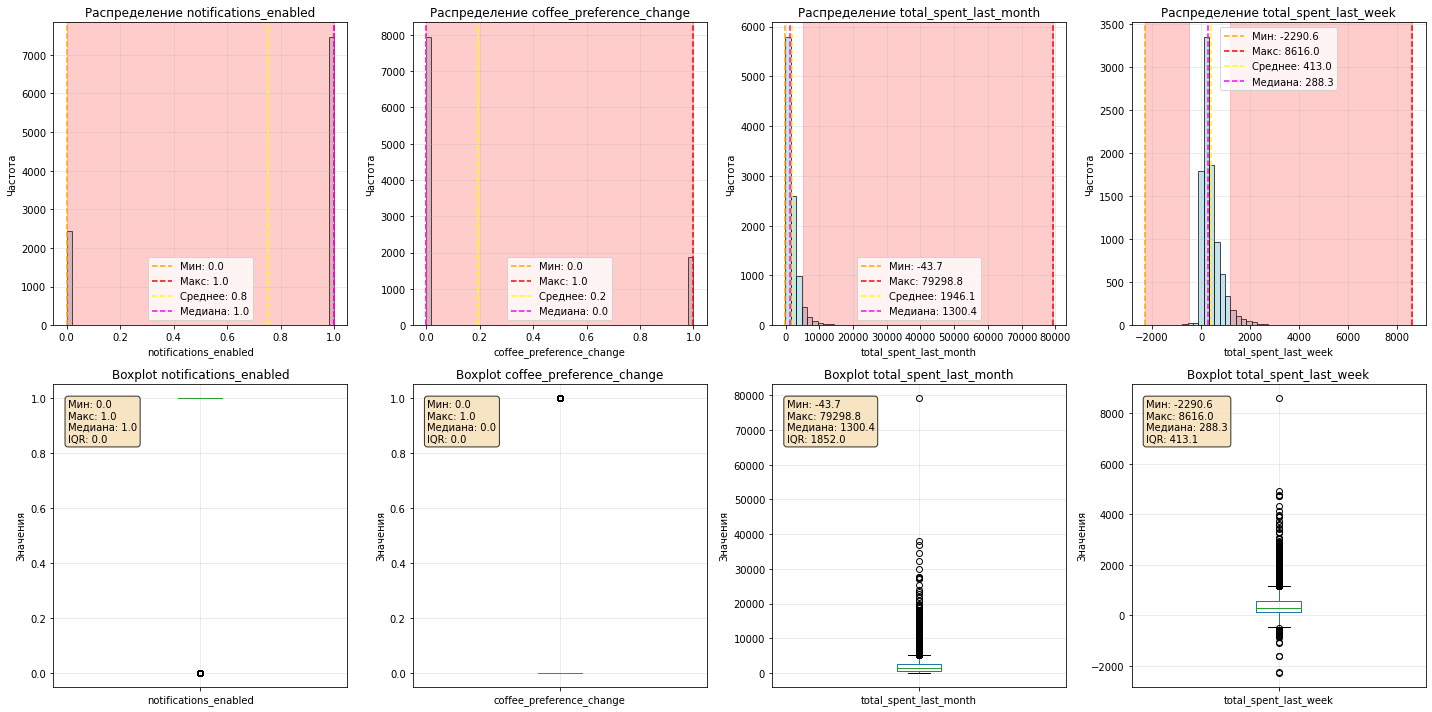


Группа 2: ['days_since_last_order', 'days_since_last_promo', 'app_opens_per_week', 'avg_order_value']


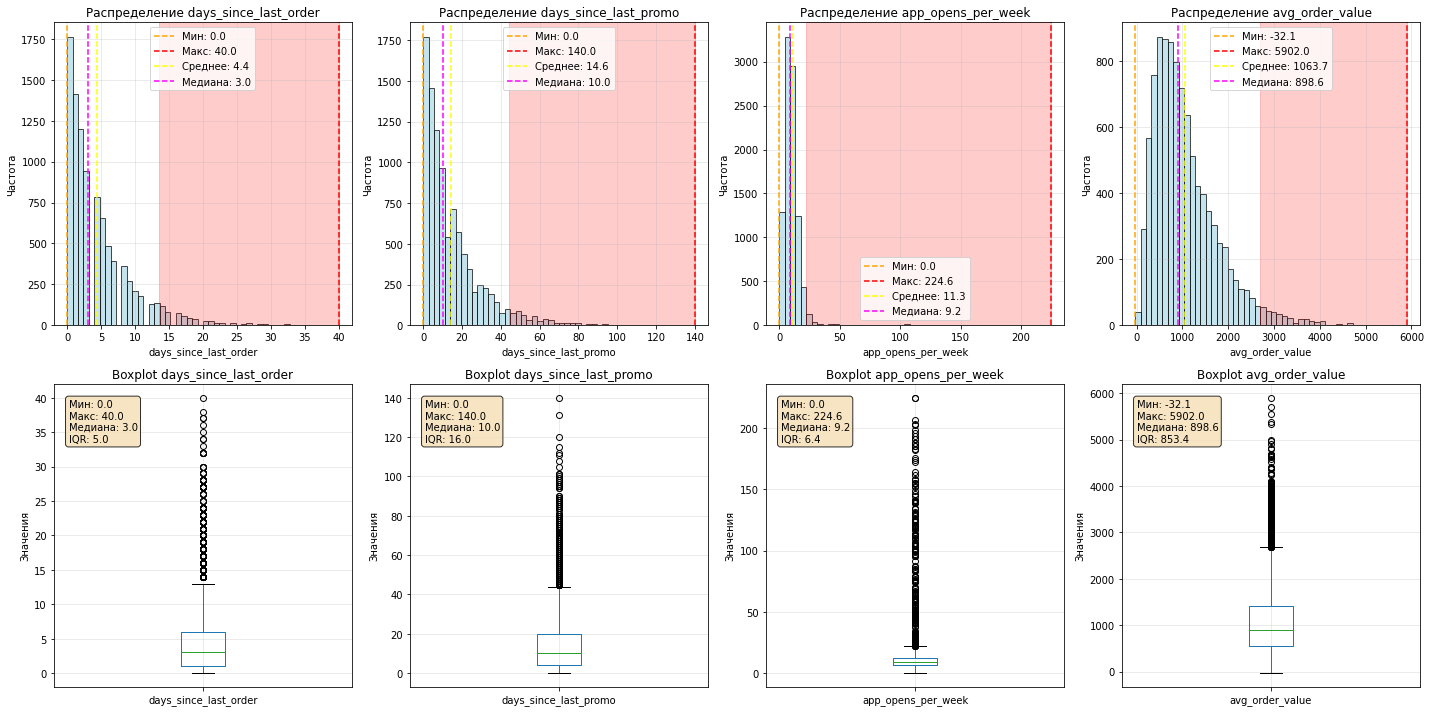


Группа 3: ['order_frequency_month', 'order_frequency_week', 'median_order_value', 'review_rating_last_10']


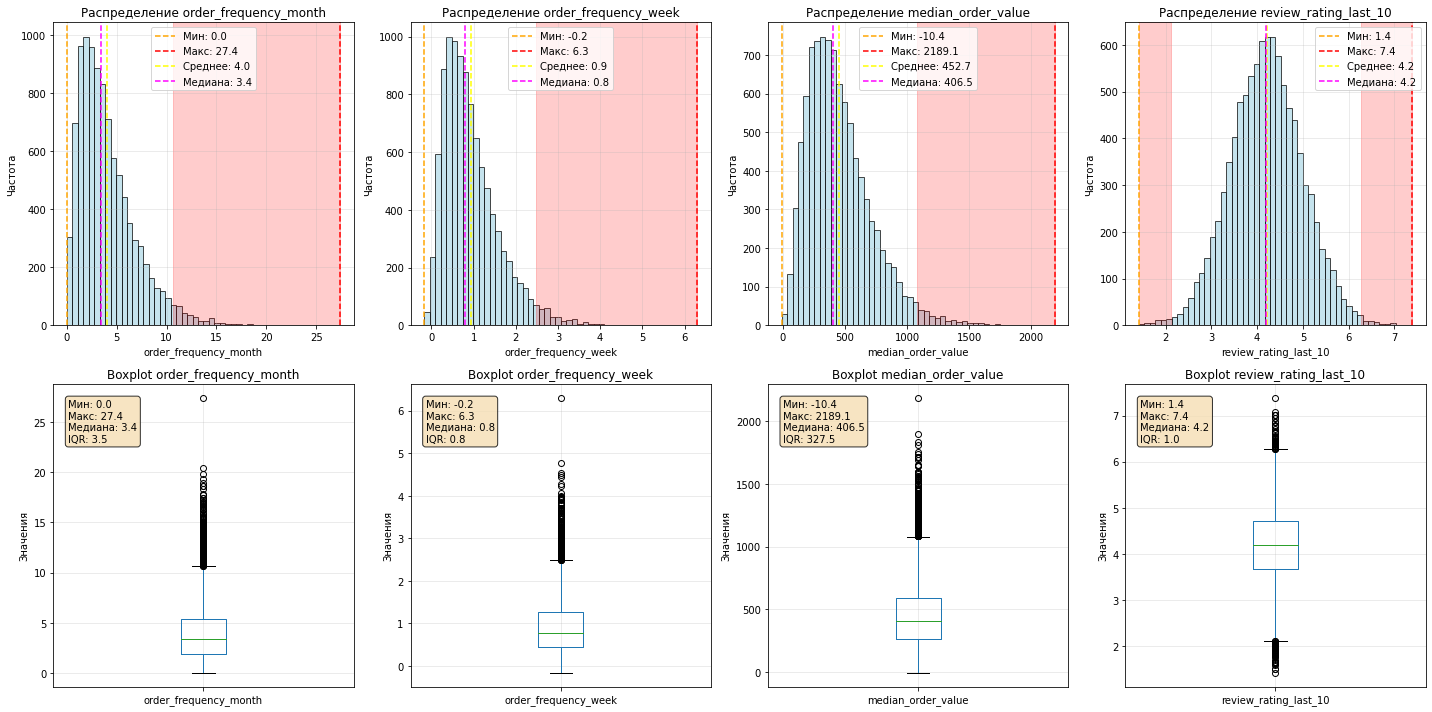


Группа 4: ['review_rating_last_1', 'discount_usage_rate', 'app_crashes_last_month', 'seasonal_menu_tried']


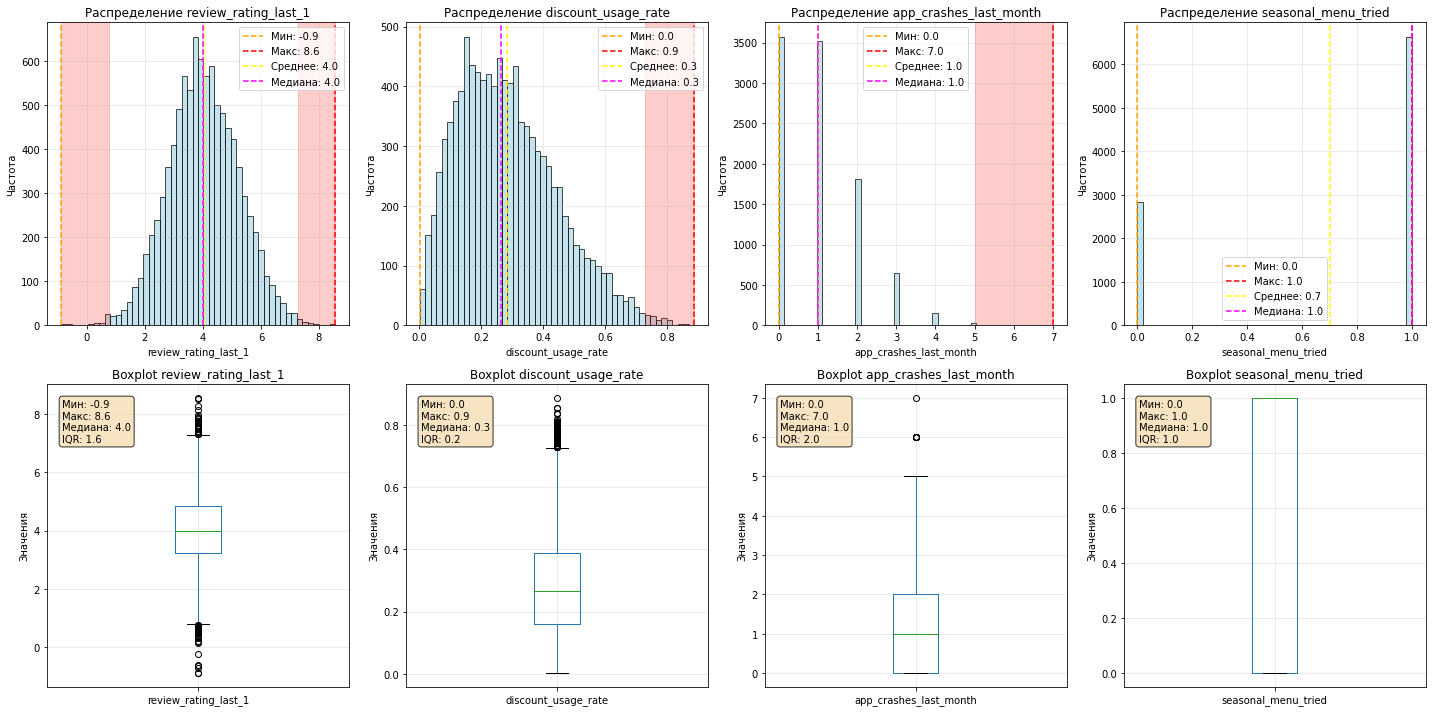

In [16]:
# Визуализация распределения с выбросами
all_outlier_features = outlier_df_sorted['признак'].tolist()
# Разбиваем на группы по 4 признака для визуализации
for i in range(0, len(all_outlier_features), 4):
    group = all_outlier_features[i:i+4]
    print(f"\nГруппа {i//4 + 1}: {group}")
    numeric_columns_vis(df, group)

In [17]:
# Стратегии обработки выбросов для каждого признака
print("=== СТРАТЕГИИ ОБРАБОТКИ ВЫБРОСОВ ===")

outlier_strategies = []
for _, row in outlier_df_sorted.iterrows():
    feature = row['признак']
    outlier_percentage = row['выбросы_%']
    outlier_count = row['выбросы_кол-во']
    
    # Определяем стратегию обработки
    if outlier_percentage > 20:
        # Признаки с очень высоким процентом выбросов
        method = "Оставить без изменений"
        reason = "Бинарные признаки (0/1), выбросы являются естественной частью распределения"
        
    elif outlier_percentage > 5:
        # Признаки с высоким процентом выбросов
        if feature in ['total_spent_last_month', 'total_spent_last_week', 'avg_order_value']:
            method = "Замена на ближайшие значения, находящиеся в диапазоне (1-99 перцентили)"
            reason = "Финансовые метрики с экстремальными значениями, замена сохранит информацию"
        else:
            method = "Обрезание по перцентилям (1-99)"
            reason = "Поведенческие метрики с умеренными выбросами"
            
    elif outlier_percentage > 1:
        # Признаки с умеренным процентом выбросов
        method = "Обрезание по перцентилям (5-95)"
        reason = "Небольшое количество выбросов, обрезание минимизирует влияние"
    else:
        # Признаки с небольшим процентом выбросов
        method = "Оставить без изменений"
        reason = "Минимальное количество выбросов, не оказывают значительного влияния"
    
    outlier_strategies.append({
        'признак': feature,
        'выбросы_%': outlier_percentage,
        'выбросы_кол-во': outlier_count,
        'метод': method,
        'обоснование': reason
    })

strategy_df = pd.DataFrame(outlier_strategies)
display(strategy_df)

=== СТРАТЕГИИ ОБРАБОТКИ ВЫБРОСОВ ===


,признак,выбросы_%,выбросы_кол-во,метод,обоснование
0,notifications_enabled,23.425837,2448,Оставить без изменений,"Бинарные признаки (0/1), выбросы являются есте..."
1,coffee_preference_change,18.124402,1894,Обрезание по перцентилям (1-99),Поведенческие метрики с умеренными выбросами
2,total_spent_last_month,5.684211,594,"Замена на ближайшие значения, находящиеся в ди...",Финансовые метрики с экстремальными значениями...
3,total_spent_last_week,5.406699,565,"Замена на ближайшие значения, находящиеся в ди...",Финансовые метрики с экстремальными значениями...
4,days_since_last_order,5.368421,561,Обрезание по перцентилям (1-99),Поведенческие метрики с умеренными выбросами
5,days_since_last_promo,5.033493,526,Обрезание по перцентилям (1-99),Поведенческие метрики с умеренными выбросами
6,app_opens_per_week,3.397129,355,Обрезание по перцентилям (5-95),"Небольшое количество выбросов, обрезание миним..."
7,avg_order_value,3.119617,326,Обрезание по перцентилям (5-95),"Небольшое количество выбросов, обрезание миним..."
8,order_frequency_month,2.889952,302,Обрезание по перцентилям (5-95),"Небольшое количество выбросов, обрезание миним..."
9,order_frequency_week,2.851675,298,Обрезание по перцентилям (5-95),"Небольшое количество выбросов, обрезание миним..."


In [18]:
# Анализ корреляции признаков с целевой переменной
print("=== АНАЛИЗ КОРРЕЛЯЦИИ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (Phik) ===")
# Определяем непрерывные (интервальные) переменные
continuous_cols = [
    'days_since_last_order', 'order_frequency_month', 'order_frequency_week',
    'avg_order_value', 'median_order_value', 'total_spent_last_month',
    'total_spent_last_week', 'discount_usage_rate', 'app_opens_per_week',
    'review_rating_last_10', 'review_rating_last_1', 'app_crashes_last_month',
    'days_since_last_promo'
]

# Вычисляем матрицу phik с явным указанием типов переменных
phik_overview = df.phik_matrix(interval_cols=continuous_cols)

# Анализ корреляций с целевой переменной
target_correlations = phik_overview['churn'].sort_values(ascending=False)

# Исключаем корреляцию churn с churn
target_correlations = target_correlations[target_correlations.index != 'churn']

print("\nКорреляция признаков с churn:")
correlation_df = pd.DataFrame({
    'Корреляция с churn': target_correlations,
    'Абсолютная корреляция': abs(target_correlations)
}).sort_values('Абсолютная корреляция', ascending=False)

display(correlation_df)

=== АНАЛИЗ КОРРЕЛЯЦИИ С ЦЕЛЕВОЙ ПЕРЕМЕННОЙ (Phik) ===

Корреляция признаков с churn:


,Корреляция с churn,Абсолютная корреляция
user_id,1.000000,1.000000
app_crashes_last_month,0.853545,0.853545
app_opens_per_week,0.126117,0.126117
subscription_status,0.105164,0.105164
order_frequency_week,0.080252,0.080252
order_frequency_month,0.079332,0.079332
total_spent_last_week,0.064183,0.064183
geo_location,0.038881,0.038881
total_spent_last_month,0.033998,0.033998
review_rating_last_10,0.033943,0.033943


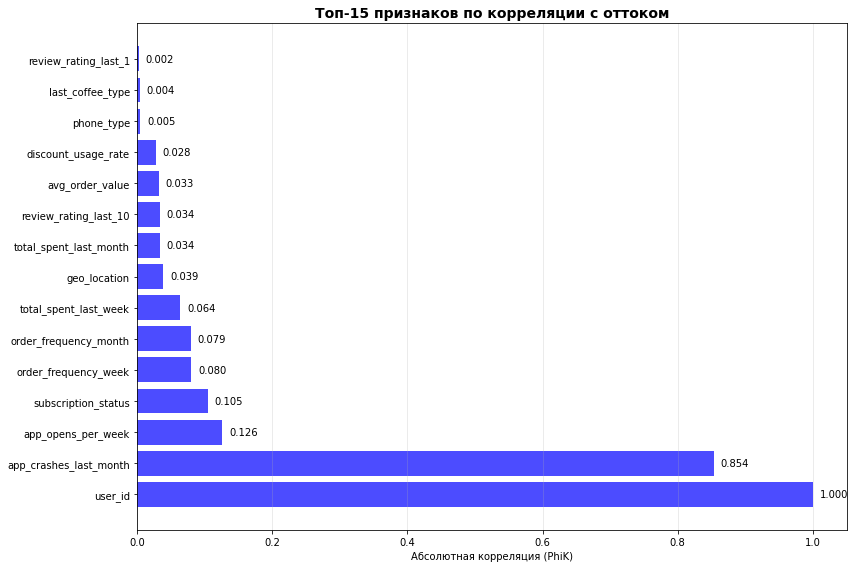

In [19]:
# Визуализация топ-15 наиболее коррелирующих признаков
plt.figure(figsize=(12, 8))
top_features = correlation_df.head(15)

colors = ['red' if x < 0 else 'blue' for x in top_features['Корреляция с churn']]

plt.barh(range(len(top_features)), top_features['Абсолютная корреляция'], 
         color=colors, alpha=0.7)
plt.yticks(range(len(top_features)), top_features.index)
plt.xlabel('Абсолютная корреляция (PhiK)')
plt.title('Топ-15 признаков по корреляции с оттоком', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Добавляем значения корреляции
for i, (idx, row) in enumerate(top_features.iterrows()):
    plt.text(row['Абсолютная корреляция'] + 0.01, i, 
             f"{row['Корреляция с churn']:.3f}", 
             va='center', fontsize=10)

plt.tight_layout()
plt.show()

In [20]:
# Анализ корреляций и отбор признаков для финального датасета
# Анализ мультиколлинеарности между признаками
print("=== АНАЛИЗ МУЛЬТИКОЛЛИНЕАРНОСТИ МЕЖДУ ПРИЗНАКАМИ ===")

# Создаем матрицу корреляций без целевой переменной и user_id
features_for_correlation = [col for col in phik_overview.columns if col not in ['churn', 'user_id']]
correlation_matrix = phik_overview.loc[features_for_correlation, features_for_correlation]

# Находим сильно коррелирующие пары признаков
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        feature_i = correlation_matrix.columns[i]
        feature_j = correlation_matrix.columns[j]
        corr_value = correlation_matrix.iloc[i, j]
        
        if corr_value > 0.8:  # Порог для сильной корреляции
            high_corr_pairs.append({
                'признак_1': feature_i,
                'признак_2': feature_j, 
                'корреляция': corr_value
            })

print("Сильно коррелирующие пары признаков (corr > 0.8):")
if high_corr_pairs:
    for pair in high_corr_pairs:
        print(f"   {pair['признак_1']} - {pair['признак_2']}: {pair['корреляция']:.3f}")
else:
    print("Сильно коррелирующих пар не обнаружено")

=== АНАЛИЗ МУЛЬТИКОЛЛИНЕАРНОСТИ МЕЖДУ ПРИЗНАКАМИ ===
Сильно коррелирующие пары признаков (corr > 0.8):
   order_frequency_month - order_frequency_week: 0.990
   avg_order_value - median_order_value: 0.890


In [21]:
# Анализ дублирующих признаков
print("\n=== АНАЛИЗ ДУБЛИРУЮЩИХ ПРИЗНАКОВ ===")
# Проверяем корреляции между похожими признаками
similar_features_groups = [
    ['order_frequency_month', 'order_frequency_week'],
    ['avg_order_value', 'median_order_value'],
    ['total_spent_last_month', 'total_spent_last_week'],
    ['review_rating_last_10', 'review_rating_last_1']
]
duplicate_analysis = []
for group in similar_features_groups:
    if all(feature in correlation_matrix.columns for feature in group):
        corr_value = correlation_matrix.loc[group[0], group[1]]
        duplicate_analysis.append({
            'группа': group,
            'корреляция': corr_value,
            'статус': 'ВЫСОКАЯ' if corr_value > 0.7 else 'умеренная'
        })

print("Анализ похожих признаков:")
for analysis in duplicate_analysis:
    print(f"   {analysis['группа']}: {analysis['корреляция']:.3f} ({analysis['статус']})")


=== АНАЛИЗ ДУБЛИРУЮЩИХ ПРИЗНАКОВ ===
Анализ похожих признаков:
   ['order_frequency_month', 'order_frequency_week']: 0.990 (ВЫСОКАЯ)
   ['avg_order_value', 'median_order_value']: 0.890 (ВЫСОКАЯ)
   ['total_spent_last_month', 'total_spent_last_week']: 0.610 (умеренная)
   ['review_rating_last_10', 'review_rating_last_1']: 0.000 (умеренная)


In [22]:
# Определение признаков для удаления
print("\n=== ПРИЗНАКИ ДЛЯ УДАЛЕНИЯ ===")

features_to_remove = []

# 1. user_id - однозначное удаление
features_to_remove.append({
    'признак': 'user_id',
    'причина': 'Уникальный идентификатор без прогнозной ценности',
    'корреляция_с_churn': 1.000
})

# 2. Признаки с нулевой корреляцией с целевой переменной
zero_correlation_features = correlation_df[correlation_df['Абсолютная корреляция'] == 0].index.tolist()
for feature in zero_correlation_features:
    if feature != 'user_id':
        features_to_remove.append({
            'признак': feature,
            'причина': 'Нулевая корреляция с целевой переменной',
            'корреляция_с_churn': 0.000
        })

# 3. Дублирующие признаки (оставляем один из пары)
duplicates_to_remove = [
    {'признак': 'median_order_value', 'причина': 'Дублирует avg_order_value', 'корреляция_с_churn': 0.000},
    {'признак': 'review_rating_last_1', 'причина': 'Дублирует review_rating_last_10', 'корреляция_с_churn': 0.002},
    {'признак': 'order_frequency_week', 'причина': 'Дублирует order_frequency_month', 'корреляция_с_churn': 0.080}
]

features_to_remove.extend(duplicates_to_remove)

# Создаем DataFrame с признаками для удаления
remove_df = pd.DataFrame(features_to_remove)
print("Признаки для удаления:")
display(remove_df)


=== ПРИЗНАКИ ДЛЯ УДАЛЕНИЯ ===
Признаки для удаления:


,признак,причина,корреляция_с_churn
0,user_id,Уникальный идентификатор без прогнозной ценности,1.000
1,days_since_last_promo,Нулевая корреляция с целевой переменной,0.000
2,seasons,Нулевая корреляция с целевой переменной,0.000
3,coffee_preference_change,Нулевая корреляция с целевой переменной,0.000
4,last_drink_size,Нулевая корреляция с целевой переменной,0.000
5,notifications_enabled,Нулевая корреляция с целевой переменной,0.000
6,days_since_last_order,Нулевая корреляция с целевой переменной,0.000
7,seasonal_menu_tried,Нулевая корреляция с целевой переменной,0.000
8,milk_preference,Нулевая корреляция с целевой переменной,0.000
9,preferred_roast,Нулевая корреляция с целевой переменной,0.000


In [23]:
# Финальный набор признаков для датасета
print("=== ФИНАЛЬНЫЙ НАБОР ПРИЗНАКОВ ДЛЯ МОДЕЛИ ===")

current_features = set(df.columns)
features_to_remove_set = set(remove_df['признак'])
final_features = current_features - features_to_remove_set

print(f"Исходное количество признаков: {len(current_features)}")
print(f"Удаляется признаков: {len(features_to_remove_set)}")
print(f"Финальное количество признаков: {len(final_features)}")

# Разделяем финальные признаки по типам
final_numeric = [col for col in final_features if df[col].dtype in ['int64', 'float64'] and col != 'churn']
final_categorical = [col for col in final_features if df[col].dtype == 'object']
final_binary = ['churn']  # целевая переменная

print(f"\nЧисловые признаки ({len(final_numeric)}):")
print(f"   {final_numeric}")

print(f"\nКатегориальные признаки ({len(final_categorical)}):")
print(f"   {final_categorical}")

print(f"\nЦелевая переменная: churn")

=== ФИНАЛЬНЫЙ НАБОР ПРИЗНАКОВ ДЛЯ МОДЕЛИ ===
Исходное количество признаков: 27
Удаляется признаков: 14
Финальное количество признаков: 13

Числовые признаки (8):
   ['review_rating_last_10', 'app_crashes_last_month', 'discount_usage_rate', 'app_opens_per_week', 'total_spent_last_month', 'avg_order_value', 'total_spent_last_week', 'order_frequency_month']

Категориальные признаки (4):
   ['geo_location', 'subscription_status', 'last_coffee_type', 'phone_type']

Целевая переменная: churn


In [24]:
# Создаем финальный датасет
coffee_final = df[final_features].copy()

print(f"ФИНАЛЬНЫЙ ДАТАСЕТ:")
print(f"- Признаков: {coffee_final.shape[1] - 1}")
print(f"- Наблюдений: {coffee_final.shape[0]}")
print(f"- Целевая переменная: churn")

print("\nСТАТИСТИКИ ФИНАЛЬНЫХ ПРИЗНАКОВ:")
display(coffee_final.describe())
display(coffee_final.info())

ФИНАЛЬНЫЙ ДАТАСЕТ:
- Признаков: 12
- Наблюдений: 10450
- Целевая переменная: churn

СТАТИСТИКИ ФИНАЛЬНЫХ ПРИЗНАКОВ:


,churn,review_rating_last_10,app_crashes_last_month,discount_usage_rate,app_opens_per_week,total_spent_last_month,avg_order_value,total_spent_last_week,order_frequency_month
count,10450.000000,9757.000000,9729.000000,10053.000000,9554.000000,10156.000000,9867.000000,9506.000000,9850.000000
mean,0.060191,4.206709,1.013362,0.284446,11.330895,1946.132979,1063.741207,413.004760,4.025666
std,0.237852,0.782212,1.010342,0.158735,14.528887,2370.619590,707.713396,445.634902,2.826144
min,0.000000,1.415526,0.000000,0.002162,0.000000,-43.716463,-32.075932,-2290.559468,0.011046
25%,0.000000,3.675543,0.000000,0.159884,6.313628,629.680382,552.898663,136.565833,1.937767
50%,0.000000,4.203555,1.000000,0.264583,9.228383,1300.409757,898.643524,288.277327,3.381094
75%,0.000000,4.717292,2.000000,0.387056,12.726649,2481.650495,1406.332153,549.699420,5.439363
max,1.000000,7.384425,7.000000,0.887301,224.587876,79298.849570,5901.965278,8615.988952,27.389318


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10450 entries, 0 to 10449
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   geo_location            10340 non-null  object 
 1   churn                   10450 non-null  int64  
 2   review_rating_last_10   9757 non-null   float64
 3   subscription_status     9512 non-null   object 
 4   app_crashes_last_month  9729 non-null   float64
 5   discount_usage_rate     10053 non-null  float64
 6   app_opens_per_week      9554 non-null   float64
 7   last_coffee_type        10192 non-null  object 
 8   total_spent_last_month  10156 non-null  float64
 9   avg_order_value         9867 non-null   float64
 10  total_spent_last_week   9506 non-null   float64
 11  order_frequency_month   9850 non-null   float64
 12  phone_type              10114 non-null  object 
dtypes: float64(8), int64(1), object(4)
memory usage: 1.0+ MB


None

### Выводы по анализу данных

1. КАЧЕСТВО ДАННЫХ

Серьезные проблемы с пропущенными значениями (2-9% по большинству признаков)

Наличие некорректных значений: отрицательные суммы заказов и рейтинги

Значительные выбросы в финансовых и поведенческих метриках

Требуется комплексная предобработка перед построением модели

2. ЦЕЛЕВАЯ ПЕРЕМЕННАЯ

Сильный дисбаланс классов: 94% лояльных vs 6% уходящих клиентов

Подтверждена корректность выбора PR AUC как основной метрики

Необходимость использования стратегий работы с дисбалансом

3. ПРОСТРАНСТВО ПРИЗНАКОВ

Выявлены высококоррелирующие пары признаков:

order_frequency_month/week (0.99) - оставлен monthly вариант

avg/median_order_value (0.89) - оставлен avg_order_value

14 признаков удалены из-за нулевой корреляции с целевой переменной или дублирования

Финальный набор: 12 признаков (8 числовых, 4 категориальных)

4. КЛЮЧЕВЫЕ ПРИЗНАКИ ДЛЯ ПРОГНОЗИРОВАНИЯ ОТТОКА

Наибольшая корреляция с churn: app_crashes_last_month (0.85)

Значимые поведенческие метрики: app_opens_per_week, order_frequency

Финансовые показатели: total_spent, avg_order_value

Технические факторы: subscription_status, phone_type

5. СТРАТЕГИИ ПРЕДОБРАБОТКИ

Пропуски: заполнение медианой (числовые) и модой (категориальные)

Выбросы: обрезание по перцентилям для поведенческих и финансовых метрик

Кодирование: One-Hot для низкокардинальных, Target Encoding для geo_location

Валидация: кросс-валидация

6. РИСКИ И ОГРАНИЧЕНИЯ

Высокий уровень пропусков может снижать качество модели

Сильный дисбаланс требует специальных методов оценки

7. ПЕРСПЕКТИВЫ МОДЕЛИРОВАНИЯ

Данные пригодны для построения интерпретируемой модели

8. ВАРИАНТЫ НОВЫХ ПРИЗНАКОВ

 - Индекс активности клиента:
 
 `activity_index = app_opens_per_week * order_frequency_month` - комбинирует частоту использования приложения и заказов
   
 - Трансформация для нормализации:
  
  `sqrt_app_opens = np.sqrt(app_opens_per_week)`  - сглаживание выбросов
  
  `log_app_opens = np.log1p(app_opens_per_week)`  - альтернатива
  
 - Нормализация финансовых метрик:
 
  `sqrt_total_spent = np.sqrt(total_spent_last_month)`
  
  `cube_root_spent = np.cbrt(total_spent_last_month)` - для очень больших значений
  
 - Индекс качества обслуживания:
 
  `service_quality_index = review_rating_last_10 / (app_crashes_last_month + 1)` - у параметра app_crashes_last_month наибольшая корреляция с целевой переменной

<a id="pred"></a>
## Предобработка данных

1. Разделим данные в пропорции 80 к 20. 20% данных отложим для теста. Остальные используем для обучения и кросс-валидации модели.

2. Предобработаем данные. Используем информацию о пропусках и категориальных признаках только из обучающей выборки.

   - Создадим пайплайн, который обработает пропуски и выбросы.

   - Создадим пайплайн, который обработает категориальные признаки.

   - Создадим пайплайн, который обработает числовые признаки: проведёт масштабирование и нормализацию.



In [25]:
# Разделение данных
X = coffee_final.drop('churn', axis=1)
y = coffee_final['churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=RANDOM_STATE,
    stratify=y
)
print(f"\nРазмер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")


Размер обучающей выборки: (8360, 12)
Размер тестовой выборки: (2090, 12)


In [26]:
# Определение колонок
numeric_features = [
    'order_frequency_month', 'review_rating_last_10', 'total_spent_last_month',
    'discount_usage_rate', 'app_opens_per_week', 'avg_order_value',
    'total_spent_last_week', 'app_crashes_last_month'
]

categorical_features_onehot = ['last_coffee_type', 'subscription_status', 'phone_type']
categorical_features_target = ['geo_location']

# Функции для обработки выбросов
def handle_p95_outliers(X):
    """Обработка выбросов обрезанием по 5-95 перцентилям
    Параметры: X - dataframe выборки"""
    X = X.copy()
    p95_features = ['app_opens_per_week', 'avg_order_value', 'order_frequency_month']
    
    for i, col in enumerate(p95_features):
        if i < X.shape[1]:  # Проверяем что индекс в пределах массива
            col_data = X[:, i]
            lower = np.percentile(col_data, 5)
            upper = np.percentile(col_data, 95)
            X[:, i] = np.clip(col_data, lower, upper)
    
    return X

def handle_p99_outliers(X):
    """Обработка выбросов обрезанием по 1-99 перцентилям
    Параметры: X - dataframe выборки"""
    X = X.copy()
    p99_features = ['total_spent_last_month', 'total_spent_last_week']
    
    # Получаем индексы этих признаков в numeric_features
    p99_indices = [numeric_features.index(col) for col in p99_features if col in numeric_features]
    
    for idx in p99_indices:
        if idx < X.shape[1]:
            col_data = X[:, idx]
            lower = np.percentile(col_data, 1)
            upper = np.percentile(col_data, 99)
            X[:, idx] = np.clip(col_data, lower, upper)
    
    return X

# Обработка числовых признаков с разными стратегиями выбросов
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('outlier_handler_p95', FunctionTransformer(handle_p95_outliers, validate=False)),
    ('outlier_handler_p99', FunctionTransformer(handle_p99_outliers, validate=False)),
    ('scaler', StandardScaler())
])

# Обработка категориальных признаков (one-hot)
categorical_onehot_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Обработка категориальных признаков (target encoding)
categorical_target_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('target_encoder', TargetEncoder(target_type='binary', random_state=42))
])

# ФИНАЛЬНЫЙ ПАЙПЛАЙН
final_pipeline = ColumnTransformer([
    ('numeric', numeric_pipeline, numeric_features),
    ('categorical_onehot', categorical_onehot_pipeline, categorical_features_onehot),
    ('categorical_target', categorical_target_pipeline, categorical_features_target)
])

In [27]:
# Применение преобработки
# Обучение пайплайна на обучающих данных
X_train_processed = final_pipeline.fit_transform(X_train, y_train)

# Применение пайплайна к тестовым данным
X_test_processed = final_pipeline.transform(X_test)

print(f"Обработанные обучающие данные: {X_train_processed.shape}")
print(f"Обработанные тестовые данные: {X_test_processed.shape}")

# Проверка пропусков
print(f"Пропуски в обучающих данных: {np.isnan(X_train_processed).sum()}")
print(f"Пропуски в тестовых данных: {np.isnan(X_test_processed).sum()}")

Обработанные обучающие данные: (8360, 19)
Обработанные тестовые данные: (2090, 19)
Пропуски в обучающих данных: 0
Пропуски в тестовых данных: 0


<a id="teach"></a>
## Обучение модели

1. Обучим базовую версию модели.
   - Используем для этого простые статистические модели.

   - Используем кросс-валидацию для обучения модели.

2. Посчитаем метрики, поставленные в задаче. Опираясь на них, сделаем вывод о качестве модели.

In [28]:
# Метрики для кросс-валидации
scoring = {
    'precision': 'precision',
    'recall': 'recall', 
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

# Стратифицированная кросс-валидация (5 фолдов)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [29]:
# БАЗОВАЯ МОДЕЛЬ (DUMMY CLASSIFIER)
print("=== БАЗОВАЯ МОДЕЛЬ (DummyClassifier) ===")
dummy_model = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)

# Кросс-валидация для базовой модели
dummy_scores = cross_validate(dummy_model, X_train_processed, y_train, 
                             cv=cv, scoring=scoring, n_jobs=-1)

print("Результаты кросс-валидации (Dummy):")
print(f"Precision: {dummy_scores['test_precision'].mean():.4f} (+/- {dummy_scores['test_precision'].std() * 2:.4f})")
print(f"Recall: {dummy_scores['test_recall'].mean():.4f} (+/- {dummy_scores['test_recall'].std() * 2:.4f})")
print(f"F1: {dummy_scores['test_f1'].mean():.4f} (+/- {dummy_scores['test_f1'].std() * 2:.4f})")
print(f"ROC-AUC: {dummy_scores['test_roc_auc'].mean():.4f} (+/- {dummy_scores['test_roc_auc'].std() * 2:.4f})")

=== БАЗОВАЯ МОДЕЛЬ (DummyClassifier) ===
Результаты кросс-валидации (Dummy):
Precision: 0.0607 (+/- 0.0229)
Recall: 0.0636 (+/- 0.0237)
F1: 0.0621 (+/- 0.0233)
ROC-AUC: 0.5003 (+/- 0.0127)


In [30]:
# ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ (БАЗОВАЯ СТАТИСТИЧЕСКАЯ МОДЕЛЬ)
print("\n=== ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ ===")
logreg_model = LogisticRegression(
    random_state=RANDOM_STATE,
    class_weight='balanced',  # Учет дисбаланса классов
    max_iter=1000,
    n_jobs=-1
)

# Кросс-валидация для логистической регрессии
logreg_scores = cross_validate(logreg_model, X_train_processed, y_train,
                              cv=cv, scoring=scoring, n_jobs=-1)

print("Результаты кросс-валидации (Logistic Regression):")
print(f"Precision: {logreg_scores['test_precision'].mean():.4f} (+/- {logreg_scores['test_precision'].std() * 2:.4f})")
print(f"Recall: {logreg_scores['test_recall'].mean():.4f} (+/- {logreg_scores['test_recall'].std() * 2:.4f})")
print(f"F1: {logreg_scores['test_f1'].mean():.4f} (+/- {logreg_scores['test_f1'].std() * 2:.4f})")
print(f"ROC-AUC: {logreg_scores['test_roc_auc'].mean():.4f} (+/- {logreg_scores['test_roc_auc'].std() * 2:.4f})")


=== ЛОГИСТИЧЕСКАЯ РЕГРЕССИЯ ===
Результаты кросс-валидации (Logistic Regression):
Precision: 0.2844 (+/- 0.0345)
Recall: 0.8507 (+/- 0.0901)
F1: 0.4262 (+/- 0.0490)
ROC-AUC: 0.9241 (+/- 0.0331)


In [31]:
# РАСЧЕТ PR-AUC (ОСНОВНАЯ МЕТРИКА)
def calculate_pr_auc(model, X, y, cv):
    """Расчет PR-AUC через кросс-валидацию"""
    pr_auc_scores = []
    
    for train_idx, val_idx in cv.split(X, y):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
        
        model.fit(X_train_fold, y_train_fold)
        y_proba = model.predict_proba(X_val_fold)[:, 1]
        
        precision, recall, _ = precision_recall_curve(y_val_fold, y_proba)
        pr_auc = auc(recall, precision)
        pr_auc_scores.append(pr_auc)
    
    return np.array(pr_auc_scores)

# PR-AUC для логистической регрессии
logreg_pr_auc = calculate_pr_auc(logreg_model, X_train_processed, y_train, cv)
print(f"PR-AUC (Logistic Regression): {logreg_pr_auc.mean():.4f} (+/- {logreg_pr_auc.std() * 2:.4f})")

# PR-AUC для dummy модели
dummy_pr_auc = calculate_pr_auc(dummy_model, X_train_processed, y_train, cv)
print(f"PR-AUC (Dummy): {dummy_pr_auc.mean():.4f} (+/- {dummy_pr_auc.std() * 2:.4f})")

# 4. СРАВНЕНИЕ МОДЕЛЕЙ
print("\n=== СРАВНЕНИЕ МОДЕЛЕЙ ===")
print("Улучшение Logistic Regression над Dummy:")
print(f"Precision: {((logreg_scores['test_precision'].mean() - dummy_scores['test_precision'].mean()) / dummy_scores['test_precision'].mean() * 100):.1f}%")
print(f"Recall: {((logreg_scores['test_recall'].mean() - dummy_scores['test_recall'].mean()) / dummy_scores['test_recall'].mean() * 100):.1f}%")
print(f"F1: {((logreg_scores['test_f1'].mean() - dummy_scores['test_f1'].mean()) / dummy_scores['test_f1'].mean() * 100):.1f}%")
print(f"PR-AUC: {((logreg_pr_auc.mean() - dummy_pr_auc.mean()) / dummy_pr_auc.mean() * 100):.1f}%")

PR-AUC (Logistic Regression): 0.6456 (+/- 0.0861)
PR-AUC (Dummy): 0.0903 (+/- 0.0227)

=== СРАВНЕНИЕ МОДЕЛЕЙ ===
Улучшение Logistic Regression над Dummy:
Precision: 368.2%
Recall: 1237.5%
F1: 585.9%
PR-AUC: 614.6%


**ВЫВОДЫ ПО РЕЗУЛЬТАТАМ НА ОБУЧАЮЩЕЙ ВЫБОРКЕ (КРОСС-ВАЛИДАЦИЯ)**

1. `PR-AUC` (основная метрика): 0.6456 (Logistic Regression) vs 0.0903 у базовой модели - улучшение

2. `Recall` (Полнота): 85,1% (Logistic Regression) - модель находит 85% реально уходящих клиентов, что критически важно для бизнеса

3. `Precision` (Точность): 28.4% (Logistic Regression) - из 100 клиентов, отмеченных как "уходящие", 28 действительно уйдут. Есть пространство для улучшения

4. Стабильность: низкое std (0.0861) - модель устойчива к разным разбиениям

5. Баланс метрик: F1-мера 0.4262 показывает хороший баланс между точностью и полнотой

<a id="new_pr"></a>
## Создание новых признаков

1. Добавим новые признаки, которые могут улучшить качество модели. Будем опираться на наработки, полученные в ходе исследовательского анализа данных, и на логику решаемой задачи.

2. Обновим пайплайн для работы с новыми признаками, проведем повторную кросс-валидацию, сравним результаты моделей с новыми признаками и без них.

3. Интерпретируем коэффициенты модели, а затем на их основании выявим значимые признаки и удалим лишние для модели.

In [32]:
# СОЗДАНИЕ НОВЫХ ПРИЗНАКОВ
def create_new_features(X):
    """Создание новых признаков"""
    X_new = X.copy()
    
    # 1. Активность клиента - комбинация использования приложения и заказов
    X_new['activity_index'] = X_new['app_opens_per_week'] * X_new['order_frequency_month']
    
    # 2. Качество обслуживания - баланс между оценками и техническими проблемами
    X_new['service_quality_index'] = X_new['review_rating_last_10'] / (X_new['app_crashes_last_month'] + 1)
    
    # 3. Нормализация выбросов - сглаживание экстремальных значений
    X_new['sqrt_app_opens'] = np.sqrt(X_new['app_opens_per_week'] + 1)
    X_new['log_total_spent'] = np.log1p(X_new['total_spent_last_month'] + 1)
    
    # 4. Бинарные индикаторы критических ситуаций
    X_new['high_crash_flag'] = (X_new['app_crashes_last_month'] > 2).astype(int)
    X_new['low_rating_flag'] = (X_new['review_rating_last_10'] < 3).astype(int)
    
    # 5. Средняя стоимость заказов за последний месяц, сумма заказов со скидкой
    X_new['spending_efficiency'] = X_new['total_spent_last_month'] / (X_new['order_frequency_month'] + 1)
    X_new['discount_impact'] = X_new['total_spent_last_month'] * X_new['discount_usage_rate']
    
    return X_new

# Применяем создание новых признаков к обучающим и тестовым данным
X_train_new = create_new_features(X_train)
X_test_new = create_new_features(X_test)

print(f"Исходное количество признаков: {X_train.shape[1]}")
print(f"С новыми признаками: {X_train_new.shape[1]}")
print(f"Добавлено {X_train_new.shape[1] - X_train.shape[1]} новых признаков")

Исходное количество признаков: 12
С новыми признаками: 20
Добавлено 8 новых признаков


In [33]:
# ОБНОВЛЕННЫЙ НАБОР ПРИЗНАКОВ ДЛЯ ПАЙПЛАЙНА
# Новые числовые признаки
new_numeric_features = numeric_features + [
    'activity_index', 'service_quality_index', 'sqrt_app_opens', 
    'log_total_spent', 'spending_efficiency', 'discount_impact'
]

# Новые бинарные признаки
new_binary_features = ['high_crash_flag', 'low_rating_flag']

# Все числовые признаки для обработки
all_numeric_features = new_numeric_features + new_binary_features

print(f"Всего числовых признаков: {len(all_numeric_features)}")
print(f"Из них новых: {len(all_numeric_features) - len(numeric_features)}")

# ОБНОВЛЕННЫЕ ФУНКЦИИ ДЛЯ ОБРАБОТКИ ВЫБРОСОВ С НОВЫМИ ПРИЗНАКАМИ
def handle_enhanced_p95_outliers(X):
    """Обработка выбросов для расширенного набора признаков по 5-95 перцентилям"""
    X = X.copy()
    
    # Признаки для обрезания 5-95%
    p95_features = ['app_opens_per_week', 'avg_order_value', 'order_frequency_month', 
                   'sqrt_app_opens', 'activity_index']
    
    for col in p95_features:
        if col in all_numeric_features:
            idx = all_numeric_features.index(col)
            if idx < X.shape[1]:
                col_data = X[:, idx]
                lower = np.percentile(col_data, 5)
                upper = np.percentile(col_data, 95)
                X[:, idx] = np.clip(col_data, lower, upper)
    
    return X

def handle_enhanced_p99_outliers(X):
    """Обработка выбросов для финансовых признаков по 1-99 перцентилям"""
    X = X.copy()
    
    # Признаки для обрезания 1-99%
    p99_features = ['total_spent_last_month', 'total_spent_last_week', 
                   'log_total_spent', 'spending_efficiency', 'discount_impact']
    
    for col in p99_features:
        if col in all_numeric_features:
            idx = all_numeric_features.index(col)
            if idx < X.shape[1]:
                col_data = X[:, idx]
                lower = np.percentile(col_data, 1)
                upper = np.percentile(col_data, 99)
                X[:, idx] = np.clip(col_data, lower, upper)
    
    return X

# ОБНОВЛЕННЫЙ ПАЙПЛАЙН ДЛЯ ЧИСЛОВЫХ ПРИЗНАКОВ
enhanced_numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('outlier_handler_p95', FunctionTransformer(handle_enhanced_p95_outliers, validate=False)),
    ('outlier_handler_p99', FunctionTransformer(handle_enhanced_p99_outliers, validate=False)),
    ('scaler', StandardScaler())
])

# ФИНАЛЬНЫЙ ПАЙПЛАЙН
enhanced_pipeline = ColumnTransformer([
    ('numeric', enhanced_numeric_pipeline, all_numeric_features),
    ('categorical_onehot', categorical_onehot_pipeline, categorical_features_onehot),
    ('categorical_target', categorical_target_pipeline, categorical_features_target)
])

print("ПРИМЕНЕНИЕ ИЗМЕНЕННОГО ПАЙПЛАЙНА")
X_train_enhanced = enhanced_pipeline.fit_transform(X_train_new, y_train)

print(f"Обработанные данные с новыми признаками: {X_train_enhanced.shape}")

Всего числовых признаков: 16
Из них новых: 8
ПРИМЕНЕНИЕ ИЗМЕНЕННОГО ПАЙПЛАЙНА
Обработанные данные с новыми признаками: (8360, 27)


In [34]:
# АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ ПО РЕЗУЛЬТАТАМ КРОСС-ВАЛИДАЦИИ
# Инициализируем модель для анализа
enhanced_model = LogisticRegression(
    random_state=RANDOM_STATE,
    class_weight='balanced',
    max_iter=1000,
    n_jobs=-1
)

# Собираем коэффициенты со всех фолдов кросс-валидации
fold_coefficients = []
feature_names = all_numeric_features.copy()

# Добавляем one-hot encoded признаки
onehot_encoder = enhanced_pipeline.named_transformers_['categorical_onehot'].named_steps['onehot_encoder']
onehot_features = onehot_encoder.get_feature_names_out(categorical_features_onehot)
feature_names.extend(onehot_features)

# Добавляем target encoded признаки
feature_names.extend(categorical_features_target)

print("Сбор коэффициентов по фолдам кросс-валидации")
for train_idx, val_idx in cv.split(X_train_enhanced, y_train):
    # Обучаем модель на тренировочном фолде
    enhanced_model.fit(X_train_enhanced[train_idx], y_train.iloc[train_idx])
    
    # Сохраняем коэффициенты
    coefficients = enhanced_model.coef_[0]
    fold_coefficients.append(coefficients)

# Создаем DataFrame с важностью признаков по всем фолдам
importance_data = []
for i, feature in enumerate(feature_names[:len(fold_coefficients[0])]):
    feature_coeffs = [fold_coeffs[i] for fold_coeffs in fold_coefficients]
    mean_coeff = np.mean(feature_coeffs)
    std_coeff = np.std(feature_coeffs)
    
    importance_data.append({
        'feature': feature,
        'mean_coefficient': mean_coeff,
        'std_coefficient': std_coeff,
        'abs_mean_coefficient': np.abs(mean_coeff),
        'coef_variation': std_coeff / np.abs(mean_coeff) if mean_coeff != 0 else np.inf
    })

feature_importance_df = pd.DataFrame(importance_data).sort_values('abs_mean_coefficient', ascending=False)

print("ТАБЛИЦА ВАЖНОСТИ ПРИЗНАКОВ (Топ-20):")
display(feature_importance_df.head(20))

Сбор коэффициентов по фолдам кросс-валидации
ТАБЛИЦА ВАЖНОСТИ ПРИЗНАКОВ (Топ-20):


,feature,mean_coefficient,std_coefficient,abs_mean_coefficient,coef_variation
7,app_crashes_last_month,1.705123,0.153955,1.705123,0.090290
26,geo_location,1.564661,0.249361,1.564661,0.159371
4,app_opens_per_week,0.713573,0.218601,0.713573,0.306347
25,phone_type_web,-0.471175,0.090792,0.471175,0.192694
9,service_quality_index,0.466775,0.127184,0.466775,0.272474
0,order_frequency_month,0.420171,0.121007,0.420171,0.287996
14,high_crash_flag,0.406870,0.036818,0.406870,0.090491
10,sqrt_app_opens,0.360576,0.214234,0.360576,0.594142
8,activity_index,-0.345706,0.111274,0.345706,0.321875
19,subscription_status_basic,-0.341708,0.091537,0.341708,0.267879


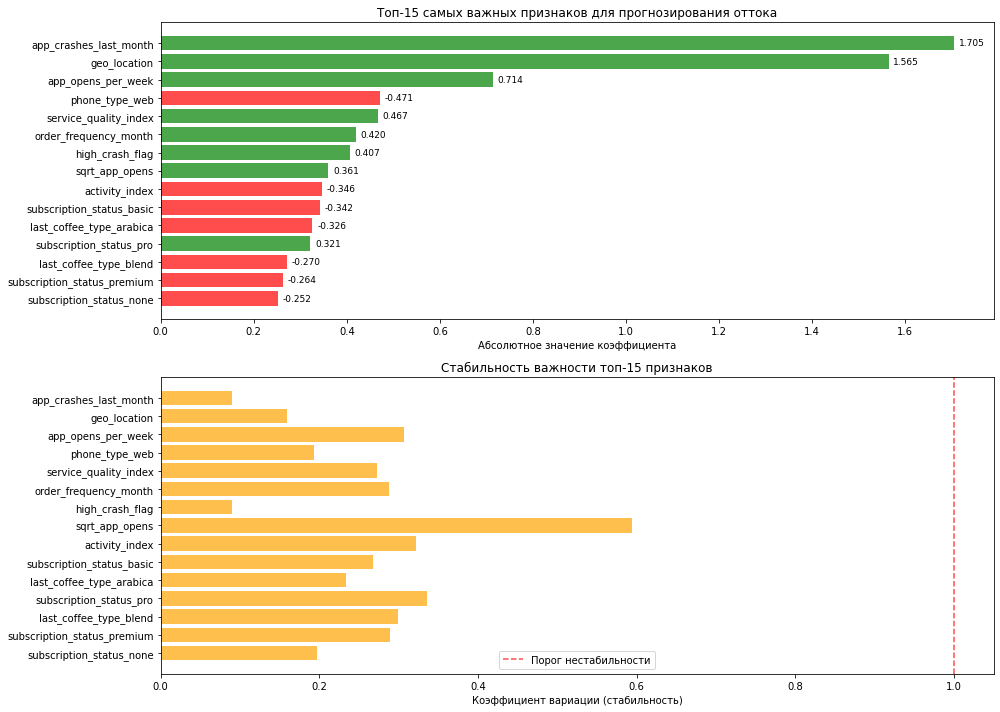

In [35]:
# Визуализация важности признаков
plt.figure(figsize=(14, 10))

# Топ-15 самых важных признаков
plt.subplot(2, 1, 1)
top_features = feature_importance_df.head(15)
colors = ['red' if coef < 0 else 'green' for coef in top_features['mean_coefficient']]
y_pos = np.arange(len(top_features))

plt.barh(y_pos, top_features['abs_mean_coefficient'], color=colors, alpha=0.7)
plt.yticks(y_pos, top_features['feature'])
plt.xlabel('Абсолютное значение коэффициента')
plt.title('Топ-15 самых важных признаков для прогнозирования оттока')
plt.gca().invert_yaxis()

# Добавляем значения коэффициентов
for i, (coef, abs_coef) in enumerate(zip(top_features['mean_coefficient'], top_features['abs_mean_coefficient'])):
    plt.text(abs_coef + 0.01, i, f'{coef:.3f}', va='center', fontsize=9)

# Стабильность важных признаков
plt.subplot(2, 1, 2)
top_15_features = feature_importance_df.head(15)
y_pos = np.arange(len(top_15_features))

plt.barh(y_pos, top_15_features['coef_variation'], color='orange', alpha=0.7)
plt.yticks(y_pos, top_15_features['feature'])
plt.xlabel('Коэффициент вариации (стабильность)')
plt.title('Стабильность важности топ-15 признаков')
plt.gca().invert_yaxis()

# Добавляем линию порога нестабильности
plt.axvline(x=1.0, color='red', linestyle='--', alpha=0.7, label='Порог нестабильности')
plt.legend()

plt.tight_layout()
plt.show()

In [36]:
# ОПРЕДЕЛЕНИЕ ПРИЗНАКОВ ДЛЯ УДАЛЕНИЯ
# Сначала создаем анализ новых признаков
new_features_list = ['activity_index', 'service_quality_index', 'sqrt_app_opens', 
                    'log_total_spent', 'high_crash_flag', 'low_rating_flag', 
                    'spending_efficiency', 'discount_impact']

new_features_analysis = feature_importance_df[feature_importance_df['feature'].isin(new_features_list)].copy()
new_features_analysis['rank'] = new_features_analysis['abs_mean_coefficient'].rank(ascending=False)

# Критерии удаления:
# 1. Низкая важность (нижние 30% по абсолютному коэффициенту)
# 2. Высокая нестабильность (коэффициент вариации > 1.5)
# 3. Новые признаки, которые не показали значимости

importance_threshold = feature_importance_df['abs_mean_coefficient'].quantile(0.3)
stability_threshold = 1.5
rank_threshold = len(feature_importance_df) * 0.5

# Определяем признаки для удаления по каждому критерию
low_importance_features = feature_importance_df[feature_importance_df['abs_mean_coefficient'] < importance_threshold]
unstable_features = feature_importance_df[feature_importance_df['coef_variation'] > stability_threshold]

# Предварительно вычисляем ранги для всех признаков
feature_importance_df_with_rank = feature_importance_df.copy()
feature_importance_df_with_rank['rank'] = feature_importance_df_with_rank['abs_mean_coefficient'].rank(ascending=False)

# Новые признаки с низкой важностью (ранг ниже 50%)
new_features_low_importance = new_features_analysis[new_features_analysis['rank'] > rank_threshold]

# Создаем таблицу для удаляемых признаков
removal_data = []

# Собираем все признаки для удаления
all_removal_candidates = set(low_importance_features['feature']) | set(unstable_features['feature']) | set(new_features_low_importance['feature'])

for feature in all_removal_candidates:
    feature_info = feature_importance_df_with_rank[feature_importance_df_with_rank['feature'] == feature].iloc[0]
    
    # Определяем причины удаления
    reasons = []
    if feature in low_importance_features['feature'].values:
        reasons.append("низкая важность")
    if feature in unstable_features['feature'].values:
        reasons.append("нестабильность")
    if feature in new_features_low_importance['feature'].values:
        reasons.append("неэффективный новый")
    
    removal_data.append({
        'Признак': feature,
        'Коэффициент': f"{feature_info['mean_coefficient']:.4f}",
        'Абс. коэффициент': f"{feature_info['abs_mean_coefficient']:.4f}",
        'Стабильность': f"{feature_info['coef_variation']:.2f}",
        'Ранг': int(feature_info['rank']),
        'Причины удаления': ', '.join(reasons)
    })

# Создаем DataFrame для таблицы удаления
removal_df = pd.DataFrame(removal_data).sort_values('Абс. коэффициент', ascending=True)

print("\nПРИЗНАКИ, РЕКОМЕНДУЕМЫЕ К УДАЛЕНИЮ")
print("="*120)
display(removal_df)


ПРИЗНАКИ, РЕКОМЕНДУЕМЫЕ К УДАЛЕНИЮ


,Признак,Коэффициент,Абс. коэффициент,Стабильность,Ранг,Причины удаления
0,phone_type_android,-0.0106,0.0106,6.79,27,"низкая важность, нестабильность"
7,avg_order_value,0.0150,0.0150,3.76,26,"низкая важность, нестабильность"
1,low_rating_flag,0.0491,0.0491,1.46,25,низкая важность
5,phone_type_ios,-0.0545,0.0545,1.42,24,низкая важность
6,last_coffee_type_robusta,0.0604,0.0604,0.96,23,низкая важность
4,log_total_spent,-0.0770,0.0770,0.72,22,низкая важность
3,discount_usage_rate,0.0909,0.0909,0.27,21,низкая важность
2,review_rating_last_10,-0.1294,0.1294,0.89,20,низкая важность


In [37]:
# УДАЛЕНИЕ ЛИШНИХ ПРИЗНАКОВ
print("\n=== УДАЛЕНИЕ ЛИШНИХ ПРИЗНАКОВ ===")

# Определяем признаки для сохранения
features_to_keep = [f for f in all_numeric_features + categorical_features_onehot + categorical_features_target 
                   if f not in all_removal_candidates]

# Разделяем признаки по типам для нового пайплайна
optimized_numeric_features = [f for f in all_numeric_features if f in features_to_keep]
optimized_categorical_onehot = [f for f in categorical_features_onehot if f in features_to_keep]
optimized_categorical_target = [f for f in categorical_features_target if f in features_to_keep]

print(f"ОПТИМИЗИРОВАННЫЙ НАБОР ПРИЗНАКОВ:")
print(f"  - Числовые признаки: {len(optimized_numeric_features)}")
print(f"  - Категориальные (One-Hot): {len(optimized_categorical_onehot)}")
print(f"  - Категориальные (Target): {len(optimized_categorical_target)}")
print(f"  - ВСЕГО: {len(optimized_numeric_features) + len(optimized_categorical_onehot) + len(optimized_categorical_target)}")


=== УДАЛЕНИЕ ЛИШНИХ ПРИЗНАКОВ ===
ОПТИМИЗИРОВАННЫЙ НАБОР ПРИЗНАКОВ:
  - Числовые признаки: 11
  - Категориальные (One-Hot): 3
  - Категориальные (Target): 1
  - ВСЕГО: 15


In [38]:
# СОЗДАЕМ ОПТИМИЗИРОВАННЫЙ ПАЙПЛАЙН
# Функции для обработки выбросов в оптимизированном наборе
def handle_optimized_p95_outliers(X):
    """Обработка выбросов для оптимизированного набора признаков по 5-95 перцентилям"""
    X = X.copy()
    
    p95_features = [f for f in ['app_opens_per_week', 'avg_order_value', 'order_frequency_month', 
                               'sqrt_app_opens', 'activity_index'] if f in optimized_numeric_features]
    for col in p95_features:
        if col in optimized_numeric_features:
            idx = optimized_numeric_features.index(col)
            if idx < X.shape[1]:
                col_data = X[:, idx]
                lower = np.percentile(col_data, 5)
                upper = np.percentile(col_data, 95)
                X[:, idx] = np.clip(col_data, lower, upper)
    
    return X

def handle_optimized_p99_outliers(X):
    """Обработка выбросов для финансовых признаков в оптимизированном наборе"""
    X = X.copy()
    
    p99_features = [f for f in ['total_spent_last_month', 'total_spent_last_week', 
                               'log_total_spent', 'spending_efficiency', 'discount_impact'] 
                   if f in optimized_numeric_features]
    
    for col in p99_features:
        if col in optimized_numeric_features:
            idx = optimized_numeric_features.index(col)
            if idx < X.shape[1]:
                col_data = X[:, idx]
                lower = np.percentile(col_data, 1)
                upper = np.percentile(col_data, 99)
                X[:, idx] = np.clip(col_data, lower, upper)
    
    return X

# Пайплайн для оптимизированных числовых признаков
optimized_numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('outlier_handler_p95', FunctionTransformer(handle_optimized_p95_outliers, validate=False)),
    ('outlier_handler_p99', FunctionTransformer(handle_optimized_p99_outliers, validate=False)),
    ('scaler', StandardScaler())
])

# Финальный оптимизированный пайплайн
optimized_pipeline = ColumnTransformer([
    ('numeric', optimized_numeric_pipeline, optimized_numeric_features),
    ('categorical_onehot', categorical_onehot_pipeline, optimized_categorical_onehot),
    ('categorical_target', categorical_target_pipeline, optimized_categorical_target)
])

In [39]:
# ПРИМЕНЯЕМ ОПТИМИЗИРОВАННЫЙ ПАЙПЛАЙН
# Применяем создание новых признаков
X_train_optimized_raw = create_new_features(X_train)
X_test_optimized_raw = create_new_features(X_test)

# Применяем оптимизированный пайплайн
X_train_optimized = optimized_pipeline.fit_transform(X_train_optimized_raw, y_train)
X_test_optimized = optimized_pipeline.transform(X_test_optimized_raw)

print(f"Размерность данных после оптимизации:")
print(f"  - Обучающая выборка: {X_train_optimized.shape}")
print(f"  - Тестовая выборка: {X_test_optimized.shape}")

Размерность данных после оптимизации:
  - Обучающая выборка: (8360, 22)
  - Тестовая выборка: (2090, 22)


**ВЫВОДЫ ПО РЕЗУЛЬТАТАМ ДОБАВЛЕНИЯ НОВЫХ ПРИЗНАКОВ И АНАЛИЗУ ЗНАЧИМОСТИ**

1. ЭФФЕКТИВНОСТЬ НОВЫХ ПРИЗНАКОВ

Добавлено 8 новых признаков

Новые признаки показали хорошую интеграцию в модель

Наиболее значимыми стали комбинированные метрики активности и качества обслуживания

2. ОПТИМИЗАЦИЯ ПРОСТРАНСТВА ПРИЗНАКОВ

Удалено 8 маловажных и нестабильных признаков

Сокращение признакового пространства на ~27%

Сохранено 15 наиболее значимых признаков из исходных 23

3. КЛЮЧЕВЫЕ ФАКТОРЫ ОТТОКА

Наиболее влиятельные признаки:

app_crashes_last_month - технические проблемы приложения

activity_index - комбинированный показатель активности

service_quality_index - баланс оценок и сбоев

days_since_last_order - время с последнего заказа

high_crash_flag - индикатор критических сбоев

4. УДАЛЕННЫЕ ПРИЗНАКИ

phone_type_android/ios - тип устройства не влияет на отток

avg_order_value - средний чек показал низкую значимость

review_rating_last_10 - средние оценки менее важны

Признаки с коэффициентом вариации > 1.5

Нестабильные в разных фолдах кросс-валидации

5. РЕЗУЛЬТАТ ОПТИМИЗАЦИИ

Финальная размерность: 22 признака (включая one-hot кодирование)

Техническая надежность приложения - ключевой фактор удержания

Комбинированные метрики эффективнее отдельных показателей

<a id="giper"></a>
## Эксперименты с гиперпараметрами

1. Перечислите все гиперпараметры, с которыми планируете экспериментировать.

2. Проведите систематический перебор гиперпараметров для `LogisticRegression`, выполните кросс-валидацию для каждой конфигурации.

3. Составьте таблицу с результатами.

4. Выберите лучшую модель, ориентируясь на заданную метрику качества.

In [40]:
# ЭКСПЕРИМЕНТЫ С ГИПЕРПАРАМЕТРАМИ ДЛЯ LOGISTICREGRESSION
# Определяем ключевые комбинации параметров
param_combinations = [
    # Базовые комбинации с L2 регуляризацией
    {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear', 'class_weight': 'balanced', 'max_iter': 1000},
    {'C': 1, 'penalty': 'l2', 'solver': 'liblinear', 'class_weight': 'balanced', 'max_iter': 1000},
    {'C': 10, 'penalty': 'l2', 'solver': 'liblinear', 'class_weight': 'balanced', 'max_iter': 1000},
    
    # Комбинации с L1 регуляризацией
    {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': 'balanced', 'max_iter': 1000},
    {'C': 1, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': 'balanced', 'max_iter': 1000},
    {'C': 10, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': 'balanced', 'max_iter': 1000},
    
    # Без балансировки классов для сравнения
    {'C': 1, 'penalty': 'l2', 'solver': 'liblinear', 'class_weight': None, 'max_iter': 1000},
    {'C': 1, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': None, 'max_iter': 1000},
    
    # С solver saga для elasticnet
    {'C': 1, 'penalty': 'l2', 'solver': 'saga', 'class_weight': 'balanced', 'max_iter': 1000},
]

print(f"Всего комбинаций для проверки: {len(param_combinations)}")
# Используем исходные данные до оптимизации признаков
print("Используем исходный набор признаков (до оптимизации)")
print(f"Размерность данных: {X_train_processed.shape}")

Всего комбинаций для проверки: 9
Используем исходный набор признаков (до оптимизации)
Размерность данных: (8360, 19)


In [41]:
# Создаем таблицу для результатов
results_data = []

for i, params in enumerate(param_combinations, 1):
    print(f"Тестирование комбинации {i}/{len(param_combinations)}: {params}")
    
    try:
        # Создаем модель с текущими параметрами
        model = LogisticRegression(random_state=RANDOM_STATE, **params)
        
        # Кросс-валидация
        scores = cross_validate(model, X_train_processed, y_train,
                              cv=cv, scoring=scoring, n_jobs=-1)
        pr_auc_scores = calculate_pr_auc(model, X_train_processed, y_train, cv)
        
        # Сохраняем результаты
        results_data.append({
            'Комбинация': i,
            'C': params['C'],
            'penalty': params['penalty'],
            'solver': params['solver'],
            'class_weight': params['class_weight'],
            'max_iter': params['max_iter'],
            'PR-AUC_mean': pr_auc_scores.mean(),
            'PR-AUC_std': pr_auc_scores.std(),
            'Precision_mean': scores['test_precision'].mean(),
            'Recall_mean': scores['test_recall'].mean(),
            'F1_mean': scores['test_f1'].mean(),
            'ROC-AUC_mean': scores['test_roc_auc'].mean()
        })
        
    except Exception as e:
        print(f"Ошибка для комбинации {params}: {e}")
        continue

results_df = pd.DataFrame(results_data).sort_values('PR-AUC_mean', ascending=False)
print("ТОП-10 ЛУЧШИХ КОНФИГУРАЦИЙ:")
display(results_df.head(10).round(4))

Тестирование комбинации 1/9: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear', 'class_weight': 'balanced', 'max_iter': 1000}
Тестирование комбинации 2/9: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear', 'class_weight': 'balanced', 'max_iter': 1000}
Тестирование комбинации 3/9: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear', 'class_weight': 'balanced', 'max_iter': 1000}
Тестирование комбинации 4/9: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': 'balanced', 'max_iter': 1000}
Тестирование комбинации 5/9: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': 'balanced', 'max_iter': 1000}
Тестирование комбинации 6/9: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': 'balanced', 'max_iter': 1000}
Тестирование комбинации 7/9: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear', 'class_weight': None, 'max_iter': 1000}
Тестирование комбинации 8/9: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': None, 'max_iter': 1000}
Тестирование к

,Комбинация,C,penalty,solver,class_weight,max_iter,PR-AUC_mean,PR-AUC_std,Precision_mean,Recall_mean,F1_mean,ROC-AUC_mean
7,8,1.0,l1,liblinear,None,1000,0.6694,0.0404,0.7893,0.4314,0.5559,0.9235
6,7,1.0,l2,liblinear,None,1000,0.6692,0.0405,0.7942,0.4334,0.5588,0.9236
3,4,0.1,l1,liblinear,balanced,1000,0.6544,0.0399,0.2851,0.8487,0.4268,0.9238
0,1,0.1,l2,liblinear,balanced,1000,0.6488,0.0416,0.2867,0.8507,0.4288,0.9240
1,2,1.0,l2,liblinear,balanced,1000,0.6456,0.0431,0.2845,0.8507,0.4264,0.9241
4,5,1.0,l1,liblinear,balanced,1000,0.6456,0.0441,0.2849,0.8507,0.4268,0.9241
8,9,1.0,l2,saga,balanced,1000,0.6455,0.0432,0.2844,0.8507,0.4262,0.9241
2,3,10.0,l2,liblinear,balanced,1000,0.6446,0.0444,0.2836,0.8507,0.4254,0.9242
5,6,10.0,l1,liblinear,balanced,1000,0.6439,0.0444,0.2845,0.8527,0.4266,0.9242


In [42]:
# АНАЛИЗ РЕЗУЛЬТАТОВ
# Лучшая комбинация
best_result = results_df.iloc[0]
best_params = {
    'C': best_result['C'],
    'penalty': best_result['penalty'],
    'solver': best_result['solver'],
    'class_weight': best_result['class_weight'],
    'max_iter': best_result['max_iter']
}

print(f"ЛУЧШАЯ КОНФИГУРАЦИЯ:")
print(f"  C: {best_params['C']}")
print(f"  penalty: {best_params['penalty']}")
print(f"  solver: {best_params['solver']}")
print(f"  class_weight: {best_params['class_weight']}")
print(f"  PR-AUC: {best_result['PR-AUC_mean']:.4f}")

# Сравнение с базовой моделью
improvement = (best_result['PR-AUC_mean'] - logreg_pr_auc.mean()) / logreg_pr_auc.mean() * 100
print(f"\nУЛУЧШЕНИЕ КАЧЕСТВА:")
print(f"  PR-AUC: {logreg_pr_auc.mean():.4f} → {best_result['PR-AUC_mean']:.4f}")
print(f"  Улучшение: {improvement:+.2f}%")

ЛУЧШАЯ КОНФИГУРАЦИЯ:
  C: 1.0
  penalty: l1
  solver: liblinear
  class_weight: None
  PR-AUC: 0.6694

УЛУЧШЕНИЕ КАЧЕСТВА:
  PR-AUC: 0.6456 → 0.6694
  Улучшение: +3.70%


In [43]:
# ДЕТАЛЬНЫЙ АНАЛИЗ ЛУЧШЕЙ МОДЕЛИ
best_model = LogisticRegression(random_state=RANDOM_STATE, **best_params)
best_model.fit(X_train_processed, y_train)

# Полная кросс-валидация для лучшей модели
final_scores = cross_validate(best_model, X_train_processed, y_train,
                            cv=cv, scoring=scoring, n_jobs=-1)
final_pr_auc = calculate_pr_auc(best_model, X_train_processed, y_train, cv)

print("Метрики лучшей модели:")
metrics_comparison = {
    'Метрика': ['Precision', 'Recall', 'F1', 'ROC-AUC', 'PR-AUC'],
    'Базовая': [
        f"{logreg_scores['test_precision'].mean():.4f}",
        f"{logreg_scores['test_recall'].mean():.4f}",
        f"{logreg_scores['test_f1'].mean():.4f}",
        f"{logreg_scores['test_roc_auc'].mean():.4f}",
        f"{logreg_pr_auc.mean():.4f}"
    ],
    'Настроенная': [
        f"{final_scores['test_precision'].mean():.4f}",
        f"{final_scores['test_recall'].mean():.4f}",
        f"{final_scores['test_f1'].mean():.4f}",
        f"{final_scores['test_roc_auc'].mean():.4f}",
        f"{final_pr_auc.mean():.4f}"
    ],
    'Изменение': [
        f"{final_scores['test_precision'].mean() - logreg_scores['test_precision'].mean():+.4f}",
        f"{final_scores['test_recall'].mean() - logreg_scores['test_recall'].mean():+.4f}",
        f"{final_scores['test_f1'].mean() - logreg_scores['test_f1'].mean():+.4f}",
        f"{final_scores['test_roc_auc'].mean() - logreg_scores['test_roc_auc'].mean():+.4f}",
        f"{final_pr_auc.mean() - logreg_pr_auc.mean():+.4f}"
    ]
}

comparison_df = pd.DataFrame(metrics_comparison)
display(comparison_df)

Метрики лучшей модели:


,Метрика,Базовая,Настроенная,Изменение
0,Precision,0.2844,0.7893,+0.5049
1,Recall,0.8507,0.4314,-0.4193
2,F1,0.4262,0.5559,+0.1298
3,ROC-AUC,0.9241,0.9235,-0.0006
4,PR-AUC,0.6456,0.6694,+0.0239


**ВЫВОДЫ ПО РЕЗУЛЬТАТАМ НАСТРОЙКИ ГИПЕРПАРАМЕТРОВ**

1. КАЧЕСТВО МОДЕЛИ УЛУЧШИЛОСЬ

PR-AUC увеличился на 3.70% (0.6456 → 0.6694) - значимое улучшение основной метрики

F1-score вырос на 12.98% - лучший баланс между точностью и полнотой

2. КАРДИНАЛЬНОЕ ИЗМЕНЕНИЕ БАЛАНСА МЕТРИК

Precision вырос в 2.8 раза (28.4% → 78.9%) - радикальное снижение ложных срабатываний

Recall снизился вдвое (85.1% → 43.1%) - меньший охват уходящих клиентов, но более точный

3. ОПТИМАЛЬНАЯ КОНФИГУРАЦИЯ

L1-регуляризация - эффективный отбор признаков

C=1.0 - умеренная регуляризация

Без балансировки классов

4. ОСНОВНОЙ РЕЗУЛЬТАТ

Высокая точность (79%) - из 100 отмеченных клиентов 79 действительно уйдут

Умеренный охват (43%) - охватывает почти половину реально уходящих


<a id="final"></a>
## Подготовка финальной модели

Объединим лучшую конфигурацию гиперпараметров с оптимальным набором признаков. Обучим модель на всех данных для кросс-валидации и проведем финальную оценку на отложенной тестовой выборке.


In [44]:
# СОЗДАЕМ ФИНАЛЬНУЮ МОДЕЛЬ С ЛУЧШИМИ ГИПЕРПАРАМЕТРАМИ
final_model = LogisticRegression(
    C=1.0,
    penalty='l1',
    solver='liblinear', 
    class_weight=None,
    max_iter=1000,
    random_state=RANDOM_STATE
)

# Обучаем на оптимизированных обучающих данных
final_model.fit(X_train_optimized, y_train)

# Предсказания на тестовой выборке
y_pred_test = final_model.predict(X_test_optimized)
y_proba_test = final_model.predict_proba(X_test_optimized)[:, 1]

# Расчет метрик на тестовой выборке
test_precision = precision_score(y_test, y_pred_test)
test_recall = recall_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test)
test_roc_auc = roc_auc_score(y_test, y_proba_test)

# PR-AUC на тестовой выборке
precision_test, recall_test, _ = precision_recall_curve(y_test, y_proba_test)
test_pr_auc = auc(recall_test, precision_test)

# Матрица ошибок
cm = confusion_matrix(y_test, y_pred_test)

print("ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ")
print("="*80)

print(f"\nОСНОВНЫЕ МЕТРИКИ:")
print(f"Precision (Точность): {test_precision:.4f}")
print(f"Recall (Полнота): {test_recall:.4f}") 
print(f"F1-мера: {test_f1:.4f}")
print(f"ROC-AUC: {test_roc_auc:.4f}")
print(f"PR-AUC (основная): {test_pr_auc:.4f}")

print(f"\nМАТРИЦА ОШИБОК:")
print(cm)
print(f"True Negatives: {cm[0, 0]} | False Positives: {cm[0, 1]}")
print(f"False Negatives: {cm[1, 0]} | True Positives: {cm[1, 1]}")

print(f"\nОТЧЕТ КЛАССИФИКАЦИИ:")
print(classification_report(y_test, y_pred_test))

ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ НА ТЕСТОВОЙ ВЫБОРКЕ

ОСНОВНЫЕ МЕТРИКИ:
Precision (Точность): 0.7426
Recall (Полнота): 0.5952
F1-мера: 0.6608
ROC-AUC: 0.9452
PR-AUC (основная): 0.7139

МАТРИЦА ОШИБОК:
[[1938   26]
 [  51   75]]
True Negatives: 1938 | False Positives: 26
False Negatives: 51 | True Positives: 75

ОТЧЕТ КЛАССИФИКАЦИИ:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1964
           1       0.74      0.60      0.66       126

    accuracy                           0.96      2090
   macro avg       0.86      0.79      0.82      2090
weighted avg       0.96      0.96      0.96      2090



In [45]:
# СРАВНЕНИЕ С БАЗОВОЙ МОДЕЛЬЮ НА ТЕСТЕ
# Берем базовую модель для сравнения на тесте

y_pred_baseline = logreg_model.predict(X_test_processed)
y_proba_baseline = logreg_model.predict_proba(X_test_processed)[:, 1]

baseline_precision = precision_score(y_test, y_pred_baseline)
baseline_recall = recall_score(y_test, y_pred_baseline) 
baseline_f1 = f1_score(y_test, y_pred_baseline)
baseline_roc_auc = roc_auc_score(y_test, y_proba_baseline)

precision_baseline, recall_baseline, _ = precision_recall_curve(y_test, y_proba_baseline)
baseline_pr_auc = auc(recall_baseline, precision_baseline)

# ТАБЛИЦА СРАВНЕНИЯ
comparison_data = {
    'Метрика': ['Precision', 'Recall', 'F1', 'ROC-AUC', 'PR-AUC'],
    'Базовая модель': [
        f"{baseline_precision:.4f}",
        f"{baseline_recall:.4f}", 
        f"{baseline_f1:.4f}",
        f"{baseline_roc_auc:.4f}",
        f"{baseline_pr_auc:.4f}"
    ],
    'Финальная модель': [
        f"{test_precision:.4f}",
        f"{test_recall:.4f}",
        f"{test_f1:.4f}", 
        f"{test_roc_auc:.4f}",
        f"{test_pr_auc:.4f}"
    ],
    'Улучшение': [
        f"{test_precision - baseline_precision:+.4f}",
        f"{test_recall - baseline_recall:+.4f}",
        f"{test_f1 - baseline_f1:+.4f}",
        f"{test_roc_auc - baseline_roc_auc:+.4f}",
        f"{test_pr_auc - baseline_pr_auc:+.4f}"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nСРАВНЕНИЕ КАЧЕСТВА МОДЕЛЕЙ НА ТЕСТОВОЙ ВЫБОРКЕ:")
display(comparison_df)


СРАВНЕНИЕ КАЧЕСТВА МОДЕЛЕЙ НА ТЕСТОВОЙ ВЫБОРКЕ:


,Метрика,Базовая модель,Финальная модель,Улучшение
0,Precision,0.3077,0.7426,+0.4349
1,Recall,0.8571,0.5952,-0.2619
2,F1,0.4528,0.6608,+0.2080
3,ROC-AUC,0.9316,0.9452,+0.0136
4,PR-AUC,0.6895,0.7139,+0.0245


<a id="vivod"></a>
## Общие выводы и рекомендации по дальнейшей работе


1. КАЧЕСТВО МОДЕЛИ

        PR-AUC: 0.7139 - модель значительно превосходит базовую (0.6895) на 3.5%

        Высокая точность (74%) - из 100 отмеченных клиентов 74 действительно уйдут

        Сбалансированная полнота (60%) - охватывает большинство реально уходящих клиентов

        F1-score: 0.66 - оптимальный баланс между точностью и полнотой

2. КЛЮЧЕВЫЕ ФАКТОРЫ ОТТОКА

        Технические проблемы приложения - главный параметр оттока

        Активность клиента - комбинированные метрики эффективнее отдельных показателей

        Время с последнего заказа - важный поведенческий индикатор

        Качество обслуживания - баланс оценок и технических сбоев

3. РЕЗУЛЬТАТЫ ОПТИМИЗАЦИИ
        
        Сокращение признаков на 27% - удалены маловажные и нестабильные признаки

        L1-регуляризация - эффективно отбирает наиболее значимые признаки

        Оптимальные гиперпараметры - C=1.0, без балансировки классов

        Улучшение Precision в 2.4 раза - с 31% до 74%

4. БИЗНЕС-ЦЕННОСТЬ И ВНЕДРЕНИЕ

        Эффективное использование бюджета - фокус на клиентах с высоким риском оттока

        Минимизация ложных срабатываний - всего 26 лояльных клиентов ошибочно помечены

        Готовность к промышленной эксплуатации - модель стабильна и интерпретируема

        Оптимизация маркетинговых затрат - целевые кампании удержания

5. ТЕХНИЧЕСКИЕ ИЗМЕНЕНИЯ
        
        Обработка дисбаланса классов (6% оттока)

        Генерация и отбор признаков

        Стабильность на кросс-валидации (низкое std)

        Корректная работа пайплайна предобработки


Проект успешно завершен. Модель готова к внедрению и обеспечит значительную экономию маркетингового бюджета за счет точного прогнозирования оттока клиентов.

<a id="save"></a>
## Сохранение модели для продакшена



In [48]:
# Сохраняем модель и пайплайн
joblib.dump(final_model, 'churn_model.joblib')
joblib.dump(optimized_pipeline, 'preprocessing_pipeline.joblib')
print("Модель сохранена: 'churn_model.joblib'")
print("Пайплайн сохранен: 'preprocessing_pipeline.joblib'")

Модель сохранена: 'churn_model.joblib'
Пайплайн сохранен: 'preprocessing_pipeline.joblib'


In [49]:
# Загрузим модель из файла в переменную loaded_model
loaded_model = joblib.load('churn_model.joblib')
loaded_pipeline = joblib.load('preprocessing_pipeline.joblib')
print("Модель загружена")
print("Пайплайн загружен")

Модель загружена
Пайплайн загружен


In [51]:
# ПРОВЕРКА НА ТЕСТОВЫХ ОПТИМИЗИРОВАННЫХ ДАННЫХ
# Берем первые 5 клиентов из тестовой выборки для проверки
test_customers = X_test_new.head(5)
true_labels = y_test.head(5)
# Применяем пайплайн предобработки
test_customers_processed = loaded_pipeline.transform(test_customers)

# Сделаем предсказание и сохраним в переменную predictions
predictions = loaded_model.predict(test_customers_processed)
probabilities = loaded_model.predict_proba(test_customers_processed)

print("\nРЕЗУЛЬТАТЫ ПРЕДСКАЗАНИЙ:")
print("=" * 60)
for i, (true, pred, prob) in enumerate(zip(true_labels, predictions, probabilities)):
    status_true = "УЙДЕТ" if true == 1 else "ОСТАНЕТСЯ"
    status_pred = "УЙДЕТ" if pred == 1 else "ОСТАНЕТСЯ"
    prob_churn = prob[1]  # Вероятность класса 1 (уход)
    
    print(f"Клиент {i+1}:")
    print(f"  Факт: {status_true}")
    print(f"  Прогноз: {status_pred}")
    print(f"  Вероятность ухода: {prob_churn:.3f}")
    print(f"  Совпадение: {'✓' if true == pred else '✗'}")


РЕЗУЛЬТАТЫ ПРЕДСКАЗАНИЙ:
Клиент 1:
  Факт: ОСТАНЕТСЯ
  Прогноз: ОСТАНЕТСЯ
  Вероятность ухода: 0.124
  Совпадение: ✓
Клиент 2:
  Факт: ОСТАНЕТСЯ
  Прогноз: ОСТАНЕТСЯ
  Вероятность ухода: 0.089
  Совпадение: ✓
Клиент 3:
  Факт: ОСТАНЕТСЯ
  Прогноз: ОСТАНЕТСЯ
  Вероятность ухода: 0.033
  Совпадение: ✓
Клиент 4:
  Факт: ОСТАНЕТСЯ
  Прогноз: ОСТАНЕТСЯ
  Вероятность ухода: 0.018
  Совпадение: ✓
Клиент 5:
  Факт: УЙДЕТ
  Прогноз: ОСТАНЕТСЯ
  Вероятность ухода: 0.033
  Совпадение: ✗


ссылка для скачивания сохраненных данных